In [391]:
#import library
from scipy.stats import norm
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
%matplotlib inline

Define the prior by multuvatiate distribution

In [392]:
mu= [0.,0.]

cov = [[ 1,  0.],
        [ 0.,  1]]


In [405]:
## initial the model

c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)
np.random.seed(121)
## define the log probability
def joint_log_post(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))

In [406]:
D

<tf.Tensor: id=113652821, shape=(1000,), dtype=float32, numpy=
array([-2.12033167e-01, -2.84929156e-01, -5.73898196e-01, -4.40310180e-01,
       -3.30110550e-01,  1.18369460e+00,  1.61537290e+00,  3.67062479e-01,
       -1.41193103e-02,  6.29641771e-01,  1.70964074e+00, -1.32698739e+00,
        4.01873112e-01, -1.91426665e-01,  1.40382600e+00, -1.96876860e+00,
       -7.90415168e-01, -7.32721627e-01,  8.77438188e-02, -5.00285983e-01,
        5.04114449e-01,  6.07406080e-01,  1.16644955e+00,  8.24424446e-01,
       -3.08672452e+00,  1.16434228e+00,  1.08265162e+00,  4.85796005e-01,
       -1.23488426e+00, -1.85888171e+00,  4.88156289e-01,  3.85894984e-01,
       -2.26521492e-01,  1.07671164e-01,  1.71999526e+00,  1.04079378e+00,
       -2.44410658e+00, -8.58170688e-02, -9.48240280e-01, -2.47713447e+00,
        1.06287646e+00,  2.19250530e-01,  7.25935876e-01,  1.94107573e-02,
       -1.37278962e+00,  4.96968478e-01,  3.12543035e-01,  2.86478817e-01,
       -9.35590744e-01, -9.02731121e-

In [407]:
x_1, y_1 = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x_1.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x_1; pos[:, :, 1] = y_1

post = np.empty(x_1.shape)

for i in range(400):
    for j in range(400):
        post[i][j] = joint_log_post(D,pos[i][j][0],pos[i][j][1])

In [408]:
joint_log_post(D,-1.,-0.1)

<tf.Tensor: id=127892910, shape=(), dtype=float32, numpy=-1839.4453>

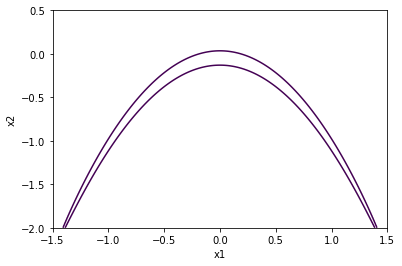

In [414]:
def draw_post():
    plt.contour(x_1, y_1, post,[joint_log_post(D,-0.,-0.13)])
    plt.xlim(-1.5,1.5)
    plt.ylim(-2,0.5)
    plt.xlabel("x1")
    plt.ylabel("x2")
draw_post()

## <b>RMH

Adjust the step size

In [415]:
num_results = 1000
burnin = 500

initial_chain_state = [
    -1.7 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

dtype = np.float32

unnormalized_posterior_log_prob = lambda *args: joint_log_post(D, *args)

# adjust the step size of Random walk Matroplis Hasting MCMC
def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

samples, kernel_results= tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=0.1, dtype=dtype),
        seed=42))  # For determinism.


samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 18.6%


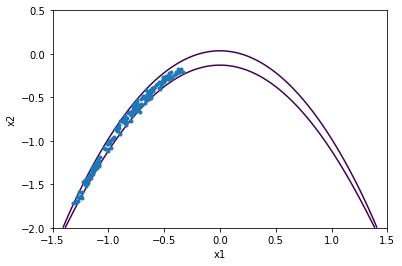

In [416]:
x_accepted = samples[np.where(accepted ==True)][:,0]
y_accepted = samples[np.where(accepted ==True)][:,1]
# f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))
draw_post()

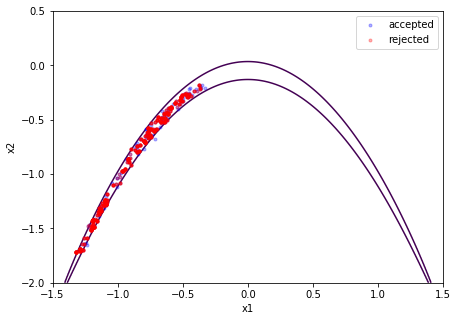

In [417]:
plt.figure(figsize=(7,5))
draw_post()
x_accepted = samples[np.where(accepted ==True)][:,0]
y_accepted = samples[np.where(accepted ==True)][:,1]
x_rejected = samples[np.where(accepted ==False)][:,0]
y_rejected = samples[np.where(accepted ==False)][:,1]

plt.xlim(-1.5,1.5)
plt.ylim(-2,0.5)
plt.plot(x_accepted,y_accepted,'b.',label = 'accepted',alpha = 0.3)
plt.plot(x_rejected,y_rejected,'r.',label = 'rejected',alpha = 0.3)
        
plt.legend(loc = 'upper right')
# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/Banana_randomwalk.png'.format(i))

<b> HMC

In [418]:
num_results = 1000
burnin = 500

initial_chain_state = [
    -1. * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1. * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [419]:
samples

array([[ 4.1946009e-02, -7.6950401e-02],
       [ 3.5939123e-02, -2.4586404e-04],
       [ 2.2977248e-02, -4.4134865e-03],
       ...,
       [ 2.0320386e-01, -7.5623758e-02],
       [ 2.6610315e-01, -6.7855135e-02],
       [ 2.1938117e-01, -1.0053151e-01]], dtype=float32)

Acceptance rate: 99.3%


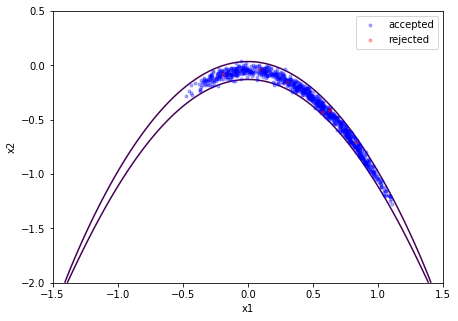

In [421]:
plt.figure(figsize=(7,5))
draw_post()
x_accepted = samples[np.where(accepted ==True)][:,0]
y_accepted = samples[np.where(accepted ==True)][:,1]
x_rejected = samples[np.where(accepted ==False)][:,0]
y_rejected = samples[np.where(accepted ==False)][:,1]

plt.xlim(-1.5,1.5)
plt.ylim(-2,0.5)
plt.plot(x_accepted,y_accepted,'b.',label = 'accepted',alpha = 0.3)
plt.plot(x_rejected,y_rejected,'r.',label = 'rejected',alpha = 0.3)
        
plt.legend(loc = 'upper right')

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


<b> Hessian MCMC - banana v1.0

Set up the target probability density

In [423]:
mean = [0.,0.]

In [424]:
joint_log_post(D,0.,0.)

<tf.Tensor: id=132664102, shape=(), dtype=float32, numpy=-1391.208>

<b> Gradient Descent

In [425]:
## Block out in case run by accident, takes too long to run 28 min
mu = tf.constant([-0.1, -0.])
for i in range(100000):
    with tf.GradientTape() as t:  
        t.watch(mu)
        theta1 = mu[0]
        theta2 = mu[1]
        loss = tf.negative(joint_log_prob(D,theta1,theta2))
        dlossdmu = t.gradient(loss,mu)
        print(mu.numpy(),dlossdmu.numpy())
        mu = mu - 0.000001*dlossdmu

[-0.1 -0. ] [-11.496093  57.48046 ]
[-9.9988505e-02 -5.7480462e-05] [-11.482812  57.420662]
[-0.09997702 -0.0001149 ] [-11.469552  57.36094 ]
[-0.09996556 -0.00017226] [-11.456313  57.301304]
[-0.0999541  -0.00022956] [-11.443085  57.2417  ]
[-0.09994265 -0.00028681] [-11.429876  57.18217 ]
[-0.09993123 -0.00034399] [-11.41668  57.12269]
[-0.09991981 -0.00040111] [-11.403505  57.063286]
[-0.0999084  -0.00045817] [-11.390346  57.00394 ]
[-0.09989701 -0.00051518] [-11.37721   56.944695]
[-0.09988564 -0.00057212] [-11.364082  56.885468]
[-0.09987427 -0.00062901] [-11.350974  56.826317]
[-0.09986292 -0.00068583] [-11.337879  56.767212]
[-0.09985158 -0.0007426 ] [-11.324803  56.708183]
[-0.09984025 -0.00079931] [-11.311738  56.649185]
[-0.09982894 -0.00085596] [-11.2986965  56.590286 ]
[-0.09981765 -0.00091255] [-11.285671  56.53144 ]
[-0.09980636 -0.00096908] [-11.272663  56.472668]
[-0.09979509 -0.00102555] [-11.25967   56.413948]
[-0.09978383 -0.00108197] [-11.246695  56.355297]
[-0.0997

[-0.09803638 -0.00991511] [-9.250019 47.17646 ]
[-0.09802713 -0.00996228] [-9.23954 47.12747]
[-0.09801789 -0.01000941] [-9.229075 47.07853 ]
[-0.09800866 -0.01005649] [-9.218623 47.029636]
[-0.09799944 -0.01010352] [-9.208185 46.980804]
[-0.09799023 -0.0101505 ] [-9.1977625 46.932037 ]
[-0.09798103 -0.01019743] [-9.187348 46.883305]
[-0.09797184 -0.01024431] [-9.176946 46.83461 ]
[-0.09796266 -0.01029115] [-9.166558 46.78598 ]
[-0.0979535  -0.01033793] [-9.156183 46.737396]
[-0.09794434 -0.01038467] [-9.145823 46.688877]
[-0.09793519 -0.01043136] [-9.135468 46.640373]
[-0.09792606 -0.010478  ] [-9.125132 46.591946]
[-0.09791693 -0.01052459] [-9.114806 46.543568]
[-0.09790782 -0.01057114] [-9.104498 46.495255]
[-0.09789871 -0.01061763] [-9.094196 46.446964]
[-0.09788962 -0.01066408] [-9.083911 46.398746]
[-0.09788053 -0.01071048] [-9.073638 46.350574]
[-0.09787146 -0.01075683] [-9.063373 46.30243 ]
[-0.0978624  -0.01080313] [-9.0531225 46.254345 ]
[-0.09785335 -0.01084939] [-9.042887 4

[-0.09643101 -0.01816996] [-7.4462857 38.609394 ]
[-0.09642357 -0.01820857] [-7.437991 38.569363]
[-0.09641613 -0.01824714] [-7.429702 38.52935 ]
[-0.0964087  -0.01828567] [-7.4214296 38.489418 ]
[-0.09640128 -0.01832416] [-7.413159 38.449482]
[-0.09639387 -0.01836261] [-7.4048963 38.40958  ]
[-0.09638646 -0.01840102] [-7.3966527 38.36977  ]
[-0.09637906 -0.01843939] [-7.3884134 38.32997  ]
[-0.09637167 -0.01847772] [-7.3801856 38.290222 ]
[-0.09636429 -0.01851601] [-7.3719683 38.25052  ]
[-0.09635692 -0.01855426] [-7.3637543 38.210823 ]
[-0.09634956 -0.01859247] [-7.355558 38.171207]
[-0.09634221 -0.01863064] [-7.3473687 38.13162  ]
[-0.09633486 -0.01866877] [-7.3391895 38.092075 ]
[-0.09632752 -0.01870687] [-7.3310175 38.05256  ]
[-0.09632019 -0.01874492] [-7.3228564 38.013092 ]
[-0.09631287 -0.01878293] [-7.3147078 37.97368  ]
[-0.09630555 -0.0188209 ] [-7.306563 37.934277]
[-0.09629824 -0.01885884] [-7.2984347 37.894955 ]
[-0.09629094 -0.01889673] [-7.2903123 37.85565  ]
[-0.096283

[-0.09527685 -0.02419047] [-6.1677732 32.367638 ]
[-0.09527069 -0.02422284] [-6.160985 32.334106]
[-0.09526452 -0.02425517] [-6.1542006 32.30059  ]
[-0.09525837 -0.02428747] [-6.1474266 32.26712  ]
[-0.09525222 -0.02431974] [-6.1406574 32.23367  ]
[-0.09524608 -0.02435197] [-6.133904 32.200294]
[-0.09523995 -0.02438417] [-6.127148 32.1669  ]
[-0.09523383 -0.02441634] [-6.1204066 32.133575 ]
[-0.09522771 -0.02444847] [-6.1136756 32.100296 ]
[-0.09522159 -0.02448057] [-6.106948 32.06703 ]
[-0.09521548 -0.02451264] [-6.100223 32.033775]
[-0.09520938 -0.02454467] [-6.0935125 32.000587 ]
[-0.09520329 -0.02457668] [-6.0868073 31.967422 ]
[-0.0951972  -0.02460864] [-6.080115 31.934315]
[-0.09519112 -0.02464058] [-6.073423 31.901205]
[-0.09518505 -0.02467248] [-6.0667453 31.868164 ]
[-0.09517898 -0.02470435] [-6.0600724 31.83514  ]
[-0.09517293 -0.02473618] [-6.053404 31.802132]
[-0.09516688 -0.02476798] [-6.046748 31.769184]
[-0.09516083 -0.02479975] [-6.0400996 31.73627  ]
[-0.09515478 -0.02

[-0.09427904 -0.02945435] [-5.0749693 26.914623 ]
[-0.09427396 -0.02948127] [-5.0694437 26.886765 ]
[-0.0942689  -0.02950815] [-5.063919 26.858908]
[-0.09426383 -0.02953501] [-5.058403 26.831093]
[-0.09425877 -0.02956184] [-5.052892 26.803299]
[-0.09425372 -0.02958865] [-5.047393 26.775562]
[-0.09424867 -0.02961542] [-5.041893 26.747818]
[-0.09424363 -0.02964217] [-5.036407 26.720144]
[-0.09423859 -0.02966889] [-5.0309205 26.692463 ]
[-0.09423357 -0.02969558] [-5.025444 26.66483 ]
[-0.09422854 -0.02972225] [-5.019967 26.637192]
[-0.09422351 -0.02974888] [-5.0145044 26.609623 ]
[-0.0942185  -0.02977549] [-5.009044 26.582062]
[-0.09421349 -0.02980208] [-5.003593 26.554546]
[-0.09420849 -0.02982863] [-4.998145 26.527042]
[-0.09420349 -0.02985516] [-4.9927073 26.499588 ]
[-0.0941985  -0.02988166] [-4.9872737 26.47215  ]
[-0.09419351 -0.02990813] [-4.9818406 26.444714 ]
[-0.09418853 -0.02993457] [-4.9764233 26.417355 ]
[-0.09418355 -0.02996099] [-4.971005 26.389984]
[-0.09417858 -0.02998738

[-0.09342805 -0.03398788] [-4.1521964 22.22136  ]
[-0.0934239 -0.0340101] [-4.1477175 22.198376 ]
[-0.09341975 -0.0340323 ] [-4.143241 22.175404]
[-0.0934156  -0.03405448] [-4.138766 22.152433]
[-0.09341147 -0.03407663] [-4.134301 22.129517]
[-0.09340733 -0.03409876] [-4.1298385 22.106607 ]
[-0.09340321 -0.03412086] [-4.1253843 22.08374  ]
[-0.09339908 -0.03414294] [-4.1209316 22.06088  ]
[-0.09339496 -0.03416501] [-4.1164894 22.03807  ]
[-0.09339084 -0.03418704] [-4.112043 22.015238]
[-0.09338672 -0.03420906] [-4.107608 21.992462]
[-0.09338262 -0.03423106] [-4.1031737 21.969687 ]
[-0.09337851 -0.03425302] [-4.098749 21.94696 ]
[-0.09337442 -0.03427497] [-4.0943246 21.924232 ]
[-0.09337032 -0.03429689] [-4.0899086 21.901546 ]
[-0.09336623 -0.03431879] [-4.085501 21.878902]
[-0.09336215 -0.03434067] [-4.081096 21.856268]
[-0.09335806 -0.03436253] [-4.076693 21.833641]
[-0.09335399 -0.03438436] [-4.072297 21.81105 ]
[-0.09334991 -0.03440617] [-4.067902 21.788464]
[-0.09334584 -0.03442796

[-0.09279308 -0.03739754] [-3.469245 18.693445]
[-0.09278961 -0.03741623] [-3.4655263 18.674107 ]
[-0.09278615 -0.03743491] [-3.461812 18.654789]
[-0.09278268 -0.03745357] [-3.4581037 18.635502 ]
[-0.09277923 -0.0374722 ] [-3.4543974 18.616222 ]
[-0.09277577 -0.03749081] [-3.450697 18.596973]
[-0.09277232 -0.03750941] [-3.446998 18.577728]
[-0.09276887 -0.03752799] [-3.4433057 18.55852  ]
[-0.09276543 -0.03754655] [-3.439614 18.53931 ]
[-0.09276199 -0.03756509] [-3.4359305 18.520144 ]
[-0.09275855 -0.03758361] [-3.4322498 18.500988 ]
[-0.09275512 -0.03760211] [-3.4285686 18.48183  ]
[-0.09275169 -0.03762059] [-3.424901 18.462742]
[-0.09274826 -0.03763905] [-3.42123  18.443634]
[-0.09274484 -0.0376575 ] [-3.4175658 18.42456  ]
[-0.09274142 -0.03767592] [-3.4139035 18.405495 ]
[-0.09273801 -0.03769433] [-3.410246 18.386452]
[-0.0927346  -0.03771272] [-3.406591 18.367422]
[-0.09273119 -0.03773108] [-3.4029462 18.348444 ]
[-0.09272779 -0.03774943] [-3.3993013 18.329464 ]
[-0.09272439 -0.03

[-0.09226226 -0.04026597] [-2.9019804 15.726801 ]
[-0.09225936 -0.04028169] [-2.8988883 15.710537 ]
[-0.09225646 -0.0402974 ] [-2.895798 15.694283]
[-0.09225357 -0.0403131 ] [-2.8927112 15.678045 ]
[-0.09225067 -0.04032878] [-2.889632 15.661847]
[-0.09224778 -0.04034444] [-2.8865507 15.6456375]
[-0.0922449  -0.04036009] [-2.88348  15.629482]
[-0.09224202 -0.04037572] [-2.880407 15.613314]
[-0.09223913 -0.04039133] [-2.8773406 15.597178 ]
[-0.09223626 -0.04040693] [-2.8742719 15.581031 ]
[-0.09223338 -0.04042251] [-2.871211 15.564923]
[-0.09223051 -0.04043807] [-2.8681526 15.548827 ]
[-0.09222765 -0.04045362] [-2.8650956 15.532738 ]
[-0.09222478 -0.04046916] [-2.8620453 15.516684 ]
[-0.09222192 -0.04048467] [-2.858996 15.500632]
[-0.09221905 -0.04050018] [-2.8559551 15.484626 ]
[-0.0922162  -0.04051566] [-2.8529136 15.468614 ]
[-0.09221335 -0.04053113] [-2.8498719 15.4526   ]
[-0.09221049 -0.04054658] [-2.8468378 15.4366255]
[-0.09220765 -0.04056202] [-2.8438077 15.420671 ]
[-0.0922048 

[-0.09179384 -0.04281095] [-2.4041922 13.095607 ]
[-0.09179144 -0.04282404] [-2.401643 13.082065]
[-0.09178904 -0.04283713] [-2.399094 13.068522]
[-0.09178664 -0.0428502 ] [-2.396556 13.055037]
[-0.09178424 -0.04286325] [-2.3940184 13.041555 ]
[-0.09178185 -0.04287629] [-2.3914762 13.028046 ]
[-0.09177946 -0.04288932] [-2.3889453 13.014597 ]
[-0.09177706 -0.04290234] [-2.3864129 13.00114  ]
[-0.09177468 -0.04291534] [-2.3838854 12.987707 ]
[-0.0917723  -0.04292832] [-2.3813562 12.974266 ]
[-0.09176991 -0.0429413 ] [-2.3788323 12.960851 ]
[-0.09176753 -0.04295426] [-2.3763103 12.947446 ]
[-0.09176516 -0.04296721] [-2.3737926 12.934063 ]
[-0.09176278 -0.04298014] [-2.3712802 12.920708 ]
[-0.09176041 -0.04299306] [-2.3687685 12.907355 ]
[-0.09175804 -0.04300597] [-2.3662572 12.894005 ]
[-0.09175567 -0.04301886] [-2.3637476 12.880662 ]
[-0.09175331 -0.04303174] [-2.3612459 12.867361 ]
[-0.09175095 -0.04304461] [-2.3587437 12.854056 ]
[-0.09174859 -0.04305746] [-2.3562453 12.840772 ]
[-0.09

[-0.09139366 -0.04499546] [-1.981008 10.837776]
[-0.09139168 -0.04500629] [-1.9789182 10.826578 ]
[-0.09138969 -0.04501712] [-1.9768318 10.815398 ]
[-0.09138772 -0.04502793] [-1.9747488 10.804235 ]
[-0.09138574 -0.04503874] [-1.972663  10.7930565]
[-0.09138377 -0.04504953] [-1.9705799 10.781892 ]
[-0.0913818  -0.04506031] [-1.9685026 10.770759 ]
[-0.09137984 -0.04507108] [-1.9664295 10.759646 ]
[-0.09137787 -0.04508184] [-1.9643519 10.74851  ]
[-0.0913759  -0.04509259] [-1.9622799 10.737404 ]
[-0.09137394 -0.04510332] [-1.9602089 10.726301 ]
[-0.09137198 -0.04511405] [-1.9581447 10.715236 ]
[-0.09137002 -0.04512476] [-1.9560772 10.704152 ]
[-0.09136806 -0.04513546] [-1.954015 10.693096]
[-0.09136611 -0.04514616] [-1.9519539 10.682045 ]
[-0.09136416 -0.04515684] [-1.9498924 10.670992 ]
[-0.09136221 -0.04516751] [-1.9478419 10.659998 ]
[-0.09136026 -0.04517817] [-1.9457837 10.648961 ]
[-0.09135832 -0.04518882] [-1.9437329 10.637963 ]
[-0.09135637 -0.04519946] [-1.9416829 10.62697  ]
[-0.

[-0.09107524 -0.04674032] [-1.645698  9.034826]
[-0.09107359 -0.04674935] [-1.6439654  9.025477 ]
[-0.09107195 -0.04675838] [-1.6422389  9.016162 ]
[-0.09107031 -0.04676739] [-1.6405092  9.006828 ]
[-0.09106867 -0.0467764 ] [-1.6387882  8.997541 ]
[-0.09106703 -0.0467854 ] [-1.637064  8.988236]
[-0.09106539 -0.04679439] [-1.6353422  8.978945 ]
[-0.09106376 -0.04680337] [-1.6336228  8.969665 ]
[-0.09106213 -0.04681234] [-1.6319108  8.960425 ]
[-0.0910605 -0.0468213] [-1.6301922  8.951149 ]
[-0.09105887 -0.04683025] [-1.6284796  8.941906 ]
[-0.09105723 -0.04683919] [-1.6267705  8.932681 ]
[-0.09105561 -0.04684812] [-1.625057  8.923431]
[-0.09105399 -0.04685704] [-1.6233479  8.914206 ]
[-0.09105236 -0.04686596] [-1.6216462  8.90502  ]
[-0.09105074 -0.04687486] [-1.619939  8.895803]
[-0.09104912 -0.04688376] [-1.6182404  8.886634 ]
[-0.0910475  -0.04689264] [-1.6165402  8.877455 ]
[-0.09104589 -0.04690152] [-1.6148409  8.86828  ]
[-0.09104427 -0.04691039] [-1.6131408  8.859101 ]
[-0.091042

[-0.09081892 -0.04814959] [-1.3766214  7.5789347]
[-0.09081754 -0.04815717] [-1.3751738  7.57108  ]
[-0.09081616 -0.04816474] [-1.3737377  7.5632887]
[-0.09081479 -0.0481723 ] [-1.3722956  7.555463 ]
[-0.09081342 -0.04817986] [-1.3708591  7.5476685]
[-0.09081205 -0.0481874 ] [-1.36942   7.539859]
[-0.09081068 -0.04819494] [-1.3679844  7.5320683]
[-0.09080931 -0.04820248] [-1.3665541  7.5243063]
[-0.09080794 -0.04821   ] [-1.3651165  7.5165033]
[-0.09080658 -0.04821752] [-1.3636866  7.5087433]
[-0.09080522 -0.04822503] [-1.3622556  7.5009766]
[-0.09080385 -0.04823253] [-1.3608297  7.4932375]
[-0.09080249 -0.04824002] [-1.3594023  7.48549  ]
[-0.09080113 -0.04824751] [-1.357982   7.4777813]
[-0.09079978 -0.04825499] [-1.3565589  7.4700565]
[-0.09079842 -0.04826245] [-1.3551376  7.4623413]
[-0.09079707 -0.04826992] [-1.353716  7.454624]
[-0.09079571 -0.04827737] [-1.3523005  7.4469404]
[-0.09079435 -0.04828482] [-1.35088   7.439229]
[-0.09079301 -0.04829226] [-1.3494685  7.431566 ]
[-0.09

[-0.09059525 -0.04938246] [-1.1424927  6.305478 ]
[-0.09059411 -0.04938876] [-1.1412991  6.29897  ]
[-0.09059297 -0.04939506] [-1.1401039  6.292453 ]
[-0.09059183 -0.04940135] [-1.1389129  6.2859583]
[-0.09059069 -0.04940764] [-1.1377234  6.2794724]
[-0.09058955 -0.04941392] [-1.1365341  6.2729874]
[-0.09058841 -0.04942019] [-1.1353439  6.2664967]
[-0.09058727 -0.04942646] [-1.1341574  6.260026 ]
[-0.09058614 -0.04943272] [-1.1329725  6.253564 ]
[-0.09058501 -0.04943897] [-1.1317924  6.2471285]
[-0.09058388 -0.04944522] [-1.1306071  6.2406645]
[-0.09058274 -0.04945146] [-1.1294266  6.234226 ]
[-0.09058161 -0.04945769] [-1.1282452  6.227783 ]
[-0.09058049 -0.04946392] [-1.127065  6.221345]
[-0.09057936 -0.04947014] [-1.1258876  6.214924 ]
[-0.09057824 -0.04947636] [-1.1247122  6.2085123]
[-0.09057711 -0.04948257] [-1.1235309  6.2020683]
[-0.09057599 -0.04948877] [-1.1223586  6.195674 ]
[-0.09057486 -0.04949496] [-1.1211865  6.1892805]
[-0.09057374 -0.04950115] [-1.1200141  6.182885 ]
[-

[-0.09040674 -0.05042392] [-0.9456361  5.2298985]
[-0.09040579 -0.05042915] [-0.9446499  5.2244987]
[-0.09040485 -0.05043437] [-0.94366455  5.219104  ]
[-0.0904039  -0.05043959] [-0.9426794  5.21371  ]
[-0.09040295 -0.0504448 ] [-0.9416969  5.20833  ]
[-0.09040201 -0.05045001] [-0.9407144  5.2029505]
[-0.09040108 -0.05045522] [-0.9397363  5.1975946]
[-0.09040014 -0.05046041] [-0.9387522  5.1922054]
[-0.0903992  -0.05046561] [-0.9377746  5.1868525]
[-0.09039826 -0.05047079] [-0.9367957  5.181492 ]
[-0.09039732 -0.05047597] [-0.9358192  5.1761446]
[-0.09039638 -0.05048115] [-0.9348422  5.1707945]
[-0.09039545 -0.05048632] [-0.9338643  5.1654387]
[-0.09039452 -0.05049149] [-0.9328917  5.1601124]
[-0.09039359 -0.05049665] [-0.9319213  5.1547976]
[-0.09039266 -0.0505018 ] [-0.9309455  5.149453 ]
[-0.09039173 -0.05050695] [-0.9299799  5.144165 ]
[-0.09039079 -0.05051209] [-0.9290076  5.1388397]
[-0.09038986 -0.05051723] [-0.92803776  5.1335278 ]
[-0.09038893 -0.05052236] [-0.9270703  5.12822

[-0.09025225 -0.05127905] [-0.78462934  4.3468685 ]
[-0.09025147 -0.0512834 ] [-0.7838104  4.342369 ]
[-0.09025069 -0.05128774] [-0.78299433  4.337886  ]
[-0.0902499  -0.05129208] [-0.78217715  4.333396  ]
[-0.09024912 -0.05129641] [-0.7813641  4.328929 ]
[-0.09024834 -0.05130074] [-0.7805503  4.324458 ]
[-0.09024756 -0.05130506] [-0.7797383  4.319997 ]
[-0.09024677 -0.05130938] [-0.7789272  4.3155403]
[-0.09024599 -0.0513137 ] [-0.7781147  4.311076 ]
[-0.09024522 -0.05131801] [-0.77730626  4.306634  ]
[-0.09024444 -0.05132231] [-0.77649796  4.3021927 ]
[-0.09024367 -0.05132662] [-0.77568847  4.2977448 ]
[-0.09024289 -0.05133092] [-0.77487886  4.293296  ]
[-0.09024212 -0.05133521] [-0.7740734  4.28887  ]
[-0.09024134 -0.0513395 ] [-0.77326846  4.2844467 ]
[-0.09024057 -0.05134378] [-0.7724623  4.280017 ]
[-0.09023979 -0.05134806] [-0.77165914  4.2756033 ]
[-0.09023902 -0.05135234] [-0.7708547  4.271183 ]
[-0.09023825 -0.05135661] [-0.77005196  4.2667713 ]
[-0.09023748 -0.05136088] [-0.

[-0.09012405 -0.05198979] [-0.651234   3.6129866]
[-0.0901234  -0.05199341] [-0.65055954  3.609271  ]
[-0.09012275 -0.05199702] [-0.64988244  3.6055403 ]
[-0.0901221  -0.05200062] [-0.64920443  3.6018047 ]
[-0.09012146 -0.05200423] [-0.6485273  3.598074 ]
[-0.09012081 -0.05200782] [-0.6478545  3.594367 ]
[-0.09012016 -0.05201142] [-0.6471845  3.5906754]
[-0.09011951 -0.05201501] [-0.6465096  3.586957 ]
[-0.09011886 -0.0520186 ] [-0.645836   3.5832453]
[-0.09011821 -0.05202218] [-0.64516354  3.5795403 ]
[-0.09011757 -0.05202576] [-0.64449507  3.5758572 ]
[-0.09011692 -0.05202934] [-0.64382493  3.5721645 ]
[-0.09011628 -0.05203291] [-0.64315534  3.5684748 ]
[-0.09011564 -0.05203648] [-0.64248574  3.564785  ]
[-0.090115   -0.05204004] [-0.6418196  3.5611143]
[-0.09011436 -0.05204361] [-0.6411499  3.5574236]
[-0.09011371 -0.05204716] [-0.6404829  3.5537481]
[-0.09011307 -0.05205072] [-0.6398202  3.5500965]
[-0.09011243 -0.05205427] [-0.63915414  3.5464258 ]
[-0.09011179 -0.05205781] [-0.63

[-0.09001762 -0.05258055] [-0.5406543  3.003047 ]
[-0.09001708 -0.05258355] [-0.5400956  2.9999619]
[-0.09001654 -0.05258655] [-0.5395349  2.9968653]
[-0.09001601 -0.05258955] [-0.53897595  2.9937782 ]
[-0.09001547 -0.05259254] [-0.53841436  2.9906769 ]
[-0.09001493 -0.05259553] [-0.5378549  2.987587 ]
[-0.0900144  -0.05259852] [-0.53729594  2.9845    ]
[-0.09001386 -0.05260151] [-0.5367385  2.9814215]
[-0.09001333 -0.05260449] [-0.53618234  2.9783497 ]
[-0.09001279 -0.05260746] [-0.5356273  2.9752846]
[-0.09001225 -0.05261044] [-0.53507185  2.9722166 ]
[-0.09001172 -0.05261341] [-0.53451014  2.9691143 ]
[-0.09001118 -0.05261638] [-0.533959   2.9660702]
[-0.09001064 -0.05261935] [-0.53340465  2.9630089 ]
[-0.09001011 -0.05262231] [-0.5328499  2.9599447]
[-0.09000957 -0.05262527] [-0.53229713  2.956892  ]
[-0.09000904 -0.05262823] [-0.53174484  2.9538412 ]
[-0.09000851 -0.05263118] [-0.5311925  2.9507904]
[-0.09000798 -0.05263413] [-0.5306392  2.9477339]
[-0.09000745 -0.05263708] [-0.53

[-0.08992927 -0.05307159] [-0.44894394  2.4960947 ]
[-0.08992882 -0.05307408] [-0.4484856  2.493559 ]
[-0.08992837 -0.05307658] [-0.4480196  2.4909801]
[-0.08992793 -0.05307907] [-0.4475515  2.48839  ]
[-0.08992748 -0.05308156] [-0.4470908  2.4858408]
[-0.08992703 -0.05308404] [-0.44662392  2.4832573 ]
[-0.08992659 -0.05308653] [-0.4461622  2.4807024]
[-0.08992614 -0.05308901] [-0.4456991  2.4781399]
[-0.08992569 -0.05309149] [-0.44523773  2.475587  ]
[-0.08992524 -0.05309396] [-0.44477275  2.4730139 ]
[-0.0899248  -0.05309644] [-0.44431362  2.4704733 ]
[-0.08992435 -0.05309891] [-0.4438533  2.467926 ]
[-0.0899239  -0.05310137] [-0.44339192  2.465373  ]
[-0.08992346 -0.05310384] [-0.4429323  2.4628296]
[-0.08992302 -0.0531063 ] [-0.44247425  2.4602947 ]
[-0.08992258 -0.05310876] [-0.4420133  2.4577436]
[-0.08992214 -0.05311122] [-0.44155627  2.4552145 ]
[-0.0899217  -0.05311367] [-0.44109926  2.4526854 ]
[-0.08992126 -0.05311612] [-0.4406426  2.450158 ]
[-0.08992082 -0.05311858] [-0.44

[-0.08985514 -0.05348388] [-0.3720931  2.0705166]
[-0.08985477 -0.05348595] [-0.37170494  2.068365  ]
[-0.0898544  -0.05348802] [-0.37132052  2.0662346 ]
[-0.08985402 -0.05349008] [-0.37093252  2.064084  ]
[-0.08985365 -0.05349215] [-0.3705517  2.0619736]
[-0.08985328 -0.05349421] [-0.3701656  2.0598335]
[-0.08985291 -0.05349627] [-0.36978564  2.0577278 ]
[-0.08985253 -0.05349833] [-0.36939868  2.055583  ]
[-0.08985216 -0.05350038] [-0.36901668  2.0534658 ]
[-0.08985179 -0.05350244] [-0.36863297  2.0513391 ]
[-0.08985142 -0.05350449] [-0.36825052  2.0492191 ]
[-0.08985106 -0.05350654] [-0.36787233  2.047123  ]
[-0.08985069 -0.05350859] [-0.3674902  2.0450048]
[-0.08985033 -0.05351063] [-0.36710638  2.0428772 ]
[-0.08984996 -0.05351267] [-0.3667289  2.0407848]
[-0.0898496  -0.05351472] [-0.36634833  2.0386753 ]
[-0.08984923 -0.05351675] [-0.3659674  2.0365639]
[-0.08984887 -0.05351879] [-0.3655896  2.0344696]
[-0.0898485  -0.05352082] [-0.36521092  2.0323706 ]
[-0.08984814 -0.05352286] 

[-0.089794   -0.05382415] [-0.30875522  1.7192421 ]
[-0.08979369 -0.05382587] [-0.30843493  1.7174644 ]
[-0.08979338 -0.05382759] [-0.30812013  1.7157173 ]
[-0.08979308 -0.05382931] [-0.30779812  1.7139301 ]
[-0.08979277 -0.05383102] [-0.30747956  1.712162  ]
[-0.08979247 -0.05383274] [-0.3071579  1.7103767]
[-0.08979216 -0.05383445] [-0.30683932  1.7086086 ]
[-0.08979186 -0.05383616] [-0.3065235  1.7068558]
[-0.08979155 -0.05383786] [-0.30620664  1.7050972 ]
[-0.08979125 -0.05383957] [-0.30589235  1.7033529 ]
[-0.08979094 -0.05384127] [-0.30557242  1.7015772 ]
[-0.08979063 -0.05384297] [-0.30525386  1.6998091 ]
[-0.08979033 -0.05384467] [-0.30494252  1.698081  ]
[-0.08979002 -0.05384637] [-0.3046231  1.6963081]
[-0.08978972 -0.05384807] [-0.3043059  1.6945477]
[-0.08978941 -0.05384976] [-0.30399626  1.6928291 ]
[-0.08978911 -0.05385145] [-0.30367926  1.6910696 ]
[-0.0897888  -0.05385314] [-0.30336243  1.689311  ]
[-0.0897885  -0.05385483] [-0.3030516  1.6875858]
[-0.08978819 -0.053856

[-0.08974326 -0.05410671] [-0.25623032  1.4275742 ]
[-0.08974301 -0.05410814] [-0.25596207  1.4260836 ]
[-0.08974276 -0.05410957] [-0.2557017  1.4246368]
[-0.0897425  -0.05411099] [-0.2554394  1.4231796]
[-0.08974225 -0.05411241] [-0.25517234  1.4216957 ]
[-0.089742   -0.05411384] [-0.2549082  1.420228 ]
[-0.08974174 -0.05411525] [-0.2546454  1.4187679]
[-0.08974149 -0.05411667] [-0.25438127  1.4173002 ]
[-0.08974124 -0.05411809] [-0.25411764  1.4158354 ]
[-0.08974098 -0.0541195 ] [-0.25385725  1.4143887 ]
[-0.08974073 -0.05412092] [-0.25359362  1.4129238 ]
[-0.08974048 -0.05412233] [-0.25333086  1.4114637 ]
[-0.08974022 -0.05412374] [-0.2530674  1.4099998]
[-0.08973997 -0.05412515] [-0.25280377  1.408535  ]
[-0.08973972 -0.05412656] [-0.2525448  1.4070959]
[-0.08973946 -0.05412797] [-0.2522834  1.4056435]
[-0.08973921 -0.05412937] [-0.25201994  1.4041796 ]
[-0.08973896 -0.05413078] [-0.25175786  1.4027233 ]
[-0.0897387  -0.05413218] [-0.2514968  1.4012728]
[-0.08973845 -0.05413358] [-

[-0.08970073 -0.05434371] [-0.21222365  1.1829538 ]
[-0.08970052 -0.05434489] [-0.21200228  1.1817226 ]
[-0.08970031 -0.05434607] [-0.21178278  1.1805019 ]
[-0.0897001  -0.05434725] [-0.21156706  1.1793022 ]
[-0.08969989 -0.05434844] [-0.21134655  1.1780758 ]
[-0.08969969 -0.05434961] [-0.2111286  1.1768637]
[-0.08969948 -0.05435079] [-0.21090809  1.1756372 ]
[-0.08969927 -0.05435197] [-0.21068998  1.1744242 ]
[-0.08969906 -0.05435314] [-0.21047477  1.1732273 ]
[-0.08969885 -0.05435431] [-0.21025546  1.1720076 ]
[-0.08969864 -0.05435549] [-0.21004026  1.1708107 ]
[-0.08969843 -0.05435666] [-0.20981821  1.1695757 ]
[-0.08969823 -0.05435783] [-0.20960198  1.1683731 ]
[-0.08969802 -0.054359  ] [-0.20938422  1.167162  ]
[-0.08969781 -0.05436016] [-0.20916937  1.165967  ]
[-0.0896976  -0.05436133] [-0.20895264  1.1647615 ]
[-0.08969739 -0.05436249] [-0.20874   1.163579]
[-0.08969718 -0.05436366] [-0.20852138  1.162363  ]
[-0.08969697 -0.05436482] [-0.20830773  1.1611748 ]
[-0.08969676 -0.05

[-0.08966588 -0.05453813] [-0.1761538  0.9822788]
[-0.0896657  -0.05453911] [-0.17597045  0.9812584 ]
[-0.08966552 -0.05454009] [-0.17578779  0.9802418 ]
[-0.08966535 -0.05454107] [-0.17560855  0.97924423]
[-0.08966517 -0.05454205] [-0.17542367  0.9782152 ]
[-0.08966499 -0.05454303] [-0.17524391  0.9772148 ]
[-0.08966481 -0.05454401] [-0.17506091  0.9761963 ]
[-0.08966464 -0.05454498] [-0.17488408  0.9752121 ]
[-0.08966447 -0.05454596] [-0.17470041  0.97418976]
[-0.0896643  -0.05454693] [-0.17452033  0.97318745]
[-0.08966412 -0.05454791] [-0.17433786  0.9721718 ]
[-0.08966395 -0.05454888] [-0.17415865  0.97117424]
[-0.08966378 -0.05454985] [-0.17398044  0.9701824 ]
[-0.08966361 -0.05455082] [-0.17380106  0.9691839 ]
[-0.08966344 -0.05455179] [-0.17362133  0.9681835 ]
[-0.08966327 -0.05455276] [-0.17344518  0.96720314]
[-0.0896631  -0.05455372] [-0.17326033  0.9661741 ]
[-0.08966292 -0.05455469] [-0.17308727  0.9652109 ]
[-0.08966275 -0.05455565] [-0.17290309  0.9641857 ]
[-0.08966258 -

[-0.0896365  -0.05470202] [-0.14577009  0.813118  ]
[-0.08963635 -0.05470283] [-0.14561854  0.812274  ]
[-0.0896362  -0.05470364] [-0.14546666  0.81142807]
[-0.08963605 -0.05470445] [-0.1453187  0.8106041]
[-0.0896359  -0.05470527] [-0.14516835  0.80976677]
[-0.08963576 -0.05470607] [-0.14501955  0.808938  ]
[-0.08963562 -0.05470688] [-0.14486682  0.80808735]
[-0.08963548 -0.05470769] [-0.14471887  0.8072634 ]
[-0.08963533 -0.0547085 ] [-0.14456649  0.8064146 ]
[-0.08963519 -0.0547093 ] [-0.14441872  0.8055916 ]
[-0.08963505 -0.05471011] [-0.14426889  0.8047571 ]
[-0.08963491 -0.05471091] [-0.14412197  0.80393887]
[-0.08963477 -0.05471172] [-0.1439725  0.8031063]
[-0.08963463 -0.05471252] [-0.1438237   0.80227757]
[-0.08963449 -0.05471332] [-0.14367439  0.80144596]
[-0.08963434 -0.05471412] [-0.14352629  0.80062103]
[-0.0896342  -0.05471493] [-0.14337766  0.79979324]
[-0.08963406 -0.05471573] [-0.14323144  0.7989788 ]
[-0.08963392 -0.05471652] [-0.14308281  0.798151  ]
[-0.08963378 -0.

[-0.08961245 -0.05483632] [-0.1208871  0.6744995]
[-0.08961233 -0.054837  ] [-0.12076576  0.67382336]
[-0.08961221 -0.05483767] [-0.12063963  0.6731205 ]
[-0.08961209 -0.05483834] [-0.1205164   0.67243385]
[-0.08961197 -0.05483902] [-0.12038822  0.67171955]
[-0.08961185 -0.05483969] [-0.12026278  0.6710205 ]
[-0.08961173 -0.05484036] [-0.12013853  0.67032814]
[-0.08961161 -0.05484103] [-0.12001907  0.6696625 ]
[-0.08961149 -0.0548417 ] [-0.11989191  0.6689539 ]
[-0.08961137 -0.05484237] [-0.11976767  0.6682615 ]
[-0.08961125 -0.05484304] [-0.1196453   0.66757965]
[-0.08961114 -0.05484371] [-0.11952208  0.666893  ]
[-0.08961102 -0.05484437] [-0.11939783  0.66620064]
[-0.0896109  -0.05484504] [-0.11927342  0.6655073 ]
[-0.08961078 -0.05484571] [-0.11914934  0.6648159 ]
[-0.08961066 -0.05484637] [-0.11902595  0.6641283 ]
[-0.08961054 -0.05484703] [-0.11890529  0.66345596]
[-0.08961042 -0.05484769] [-0.11878207  0.6627693 ]
[-0.0896103  -0.05484836] [-0.11865937  0.66208553]
[-0.08961018 -

[-0.08959284 -0.05494549] [-0.10066993  0.5618191 ]
[-0.08959273 -0.05494605] [-0.10056711  0.5612459 ]
[-0.08959264 -0.05494661] [-0.10046191  0.5606594 ]
[-0.08959254 -0.05494718] [-0.10036064  0.56009483]
[-0.08959244 -0.05494773] [-0.10025492  0.55950546]
[-0.08959235 -0.05494829] [-0.10015536  0.5589504 ]
[-0.08959225 -0.05494885] [-0.10004777  0.55835056]
[-0.08959215 -0.05494941] [-0.09994119  0.5577564 ]
[-0.08959205 -0.05494997] [-0.09984146  0.55720043]
[-0.08959196 -0.05495053] [-0.09974173  0.55664444]
[-0.08959186 -0.05495108] [-0.09963841  0.5560684 ]
[-0.08959176 -0.05495164] [-0.09953252  0.5554781 ]
[-0.08959167 -0.05495219] [-0.09942869  0.5548992 ]
[-0.08959157 -0.05495275] [-0.09932725  0.5543337 ]
[-0.08959147 -0.0549533 ] [-0.0992282  0.5537815]
[-0.08959138 -0.05495386] [-0.09912591  0.5532112 ]
[-0.08959128 -0.05495441] [-0.09901763  0.55260754]
[-0.08959118 -0.05495496] [-0.09891517  0.5520363 ]
[-0.08959109 -0.05495552] [-0.09881578  0.5514822 ]
[-0.08959099 -

[-0.08957651 -0.05503689] [-0.08375519  0.4675064 ]
[-0.08957643 -0.05503736] [-0.08366764  0.46701813]
[-0.08957635 -0.05503783] [-0.08358298  0.46654606]
[-0.08957627 -0.05503829] [-0.08349526  0.46605682]
[-0.08957618 -0.05503876] [-0.08340993  0.46558094]
[-0.0895761  -0.05503922] [-0.0833222  0.4650917]
[-0.08957602 -0.05503969] [-0.08323722  0.46461773]
[-0.08957594 -0.05504015] [-0.08315086  0.46413612]
[-0.08957586 -0.05504062] [-0.08306707  0.46366882]
[-0.08957577 -0.05504108] [-0.08298019  0.46318436]
[-0.08957569 -0.05504154] [-0.08289452  0.46270657]
[-0.08957561 -0.05504201] [-0.08280885  0.46222878]
[-0.08957553 -0.05504247] [-0.08272403  0.46175575]
[-0.08957545 -0.05504293] [-0.08263819  0.461277  ]
[-0.08957537 -0.05504339] [-0.08255286  0.46080112]
[-0.08957528 -0.05504385] [-0.08246668  0.46032047]
[-0.0895752  -0.05504432] [-0.08238322  0.45985508]
[-0.08957512 -0.05504477] [-0.08229601  0.4593687 ]
[-0.08957504 -0.05504523] [-0.08221085  0.45889378]
[-0.08957496 -

[-0.08956287 -0.05511295] [-0.06967751  0.3889866 ]
[-0.0895628  -0.05511333] [-0.06960691  0.38859272]
[-0.08956274 -0.05511372] [-0.06953818  0.38820934]
[-0.08956267 -0.05511411] [-0.06946348  0.3877926 ]
[-0.0895626 -0.0551145] [-0.06939441  0.3874073 ]
[-0.08956254 -0.05511488] [-0.06932279  0.3870077 ]
[-0.08956247 -0.05511527] [-0.06924877  0.38659477]
[-0.0895624  -0.05511566] [-0.06917696  0.38619423]
[-0.08956233 -0.05511605] [-0.06910893  0.38581467]
[-0.08956227 -0.05511643] [-0.06903354  0.3853941 ]
[-0.0895622  -0.05511682] [-0.06896379  0.385005  ]
[-0.08956213 -0.0551172 ] [-0.06889455  0.38461876]
[-0.08956207 -0.05511758] [-0.06881934  0.38419914]
[-0.089562   -0.05511797] [-0.06875078  0.38381672]
[-0.08956193 -0.05511835] [-0.06868275  0.38343716]
[-0.08956186 -0.05511874] [-0.06860787  0.38301945]
[-0.0895618  -0.05511912] [-0.06853949  0.38263798]
[-0.08956173 -0.0551195 ] [-0.06846889  0.3822441 ]
[-0.08956166 -0.05511989] [-0.06839504  0.38183212]
[-0.0895616  -

[-0.08955139 -0.0551772 ] [-0.05779314  0.32268143]
[-0.08955133 -0.05517752] [-0.05773605  0.3223629 ]
[-0.08955127 -0.05517785] [-0.05767777  0.3220377 ]
[-0.08955121 -0.05517817] [-0.05761641  0.32169533]
[-0.08955115 -0.05517849] [-0.05755591  0.32135773]
[-0.08955109 -0.05517881] [-0.0574954   0.32102013]
[-0.08955103 -0.05517913] [-0.05743712  0.32069492]
[-0.08955097 -0.05517945] [-0.0573785  0.3203678]
[-0.08955091 -0.05517977] [-0.05731834  0.32003212]
[-0.08955085 -0.05518009] [-0.05725937  0.3197031 ]
[-0.08955079 -0.05518041] [-0.05719801  0.31936073]
[-0.08955073 -0.05518073] [-0.05714332  0.31905556]
[-0.08955067 -0.05518105] [-0.05708538  0.31873226]
[-0.08955061 -0.05518137] [-0.05702112  0.31837368]
[-0.08955055 -0.05518169] [-0.05696249  0.31804657]
[-0.0895505 -0.055182 ] [-0.05690455  0.31772327]
[-0.08955044 -0.05518232] [-0.0568473  0.3174038]
[-0.08955038 -0.05518264] [-0.05678679  0.3170662 ]
[-0.08955032 -0.05518295] [-0.05672937  0.31674576]
[-0.08955026 -0.05

[-0.08954182 -0.05523023] [-0.04798376  0.26794052]
[-0.08954177 -0.0552305 ] [-0.04793677  0.26767826]
[-0.08954173 -0.05523077] [-0.04788312  0.2673788 ]
[-0.08954168 -0.05523103] [-0.04783801  0.26712704]
[-0.08954164 -0.0552313 ] [-0.0477876  0.2668457]
[-0.08954159 -0.05523157] [-0.047736   0.2665577]
[-0.08954155 -0.05523184] [-0.0476873  0.2662859]
[-0.0895415 -0.0552321] [-0.0476369   0.26600456]
[-0.08954146 -0.05523237] [-0.0475882   0.26573277]
[-0.08954141 -0.05523263] [-0.04753916  0.26545906]
[-0.08954137 -0.0552329 ] [-0.04749593  0.26521778]
[-0.08954132 -0.05523316] [-0.04744535  0.2649355 ]
[-0.08954128 -0.05523343] [-0.04739358  0.26464653]
[-0.08954123 -0.05523369] [-0.04734625  0.26438236]
[-0.08954119 -0.05523396] [-0.04729516  0.2640972 ]
[-0.08954114 -0.05523422] [-0.0472468   0.26382732]
[-0.0895411  -0.05523448] [-0.04719742  0.2635517 ]
[-0.08954106 -0.05523475] [-0.04715385  0.26330853]
[-0.08954101 -0.05523501] [-0.04710361  0.26302814]
[-0.08954097 -0.0552

[-0.0895339  -0.05527471] [-0.03976127  0.2220459 ]
[-0.08953386 -0.05527494] [-0.03971992  0.22181511]
[-0.08953382 -0.05527516] [-0.03967892  0.22158623]
[-0.08953378 -0.05527538] [-0.03963741  0.22135448]
[-0.08953375 -0.0552756 ] [-0.03959385  0.2211113 ]
[-0.08953371 -0.05527582] [-0.03955455  0.22089195]
[-0.08953367 -0.05527604] [-0.03951321  0.22066116]
[-0.08953363 -0.05527626] [-0.03947443  0.22044468]
[-0.0895336  -0.05527648] [-0.03943445  0.22022152]
[-0.08953356 -0.0552767 ] [-0.03939413  0.21999645]
[-0.08953352 -0.05527692] [-0.0393545  0.2197752]
[-0.08953349 -0.05527714] [-0.03931486  0.21955395]
[-0.08953345 -0.05527736] [-0.03927335  0.2193222 ]
[-0.08953341 -0.05527758] [-0.03923012  0.21908092]
[-0.08953337 -0.0552778 ] [-0.03919032  0.21885872]
[-0.08953334 -0.05527802] [-0.0391512   0.21864033]
[-0.0895333  -0.05527824] [-0.03910985  0.21840954]
[-0.08953326 -0.05527846] [-0.03906988  0.21818638]
[-0.08953322 -0.05527868] [-0.0390311  0.2179699]
[-0.08953319 -0.

[-0.08952723 -0.05531157] [-0.03294398  0.18398857]
[-0.0895272  -0.05531175] [-0.0329093   0.18379498]
[-0.08952717 -0.05531194] [-0.03287872  0.18362427]
[-0.08952715 -0.05531212] [-0.0328449   0.18343544]
[-0.08952712 -0.0553123 ] [-0.03280989  0.18323994]
[-0.08952709 -0.05531248] [-0.03277709  0.18305683]
[-0.08952706 -0.05531267] [-0.0327407  0.1828537]
[-0.08952703 -0.05531285] [-0.03270876  0.18267536]
[-0.089527   -0.05531303] [-0.03267375  0.18247986]
[-0.08952697 -0.05531321] [-0.03263907  0.18228626]
[-0.08952694 -0.0553134 ] [-0.03260849  0.18211555]
[-0.08952691 -0.05531358] [-0.03257297  0.18191719]
[-0.08952688 -0.05531376] [-0.03254188  0.18174362]
[-0.08952685 -0.05531394] [-0.03250498  0.18153763]
[-0.08952682 -0.05531413] [-0.03247645  0.18137836]
[-0.08952679 -0.05531431] [-0.03244007  0.18117523]
[-0.08952676 -0.05531449] [-0.03240488  0.18097878]
[-0.08952673 -0.05531467] [-0.03237277  0.18079948]
[-0.0895267  -0.05531486] [-0.03233724  0.18060112]
[-0.08952667 -

[-0.0895219  -0.05534165] [-0.0273848   0.15295029]
[-0.08952187 -0.05534181] [-0.02735781  0.1527996 ]
[-0.08952184 -0.05534196] [-0.0273327   0.15265942]
[-0.08952181 -0.05534211] [-0.02729837  0.15246773]
[-0.08952178 -0.05534226] [-0.02727105  0.15231514]
[-0.08952175 -0.05534242] [-0.02724372  0.15216255]
[-0.08952172 -0.05534257] [-0.02721331  0.1519928 ]
[-0.08952169 -0.05534272] [-0.02718684  0.15184498]
[-0.08952166 -0.05534288] [-0.02716053  0.15169811]
[-0.08952163 -0.05534303] [-0.0271286   0.15151978]
[-0.0895216  -0.05534318] [-0.02710161  0.1513691 ]
[-0.08952157 -0.05534333] [-0.02707428  0.1512165 ]
[-0.08952154 -0.05534349] [-0.02704353  0.15104485]
[-0.08952151 -0.05534364] [-0.0270186   0.15090561]
[-0.08952148 -0.05534379] [-0.02699315  0.15076351]
[-0.08952145 -0.05534394] [-0.02695967  0.15057659]
[-0.08952142 -0.05534409] [-0.02693115  0.15041733]
[-0.08952139 -0.05534424] [-0.02690638  0.15027905]
[-0.08952136 -0.05534439] [-0.02687837  0.15012264]
[-0.08952133

[-0.0895175  -0.05536692] [-0.02272188  0.12691307]
[-0.08951747 -0.05536705] [-0.02269592  0.12676811]
[-0.08951745 -0.05536717] [-0.02267457  0.1266489 ]
[-0.08951743 -0.0553673 ] [-0.02264793  0.12650013]
[-0.08951741 -0.05536743] [-0.0226259  0.1263771]
[-0.08951738 -0.05536755] [-0.02260046  0.12623501]
[-0.08951736 -0.05536768] [-0.02257996  0.12612057]
[-0.08951734 -0.05536781] [-0.02255605  0.12598705]
[-0.08951732 -0.05536793] [-0.02253282  0.12585735]
[-0.0895173  -0.05536806] [-0.02251011  0.12573051]
[-0.08951727 -0.05536819] [-0.02248688  0.12560081]
[-0.08951725 -0.05536831] [-0.02246229  0.12546349]
[-0.08951723 -0.05536844] [-0.02243821  0.12532902]
[-0.08951721 -0.05536857] [-0.02241635  0.12520695]
[-0.08951718 -0.05536869] [-0.02239056  0.12506294]
[-0.08951716 -0.05536882] [-0.02236956  0.12494564]
[-0.08951714 -0.05536895] [-0.02234189  0.12479115]
[-0.08951712 -0.05536907] [-0.02232072  0.12467289]
[-0.08951709 -0.05536919] [-0.02229834  0.12454796]
[-0.08951707 -

[-0.08951347 -0.05538777] [-0.01885597  0.10532475]
[-0.08951345 -0.05538788] [-0.01883957  0.10523319]
[-0.08951343 -0.05538798] [-0.01881925  0.10511971]
[-0.08951341 -0.05538809] [-0.01879927  0.10500813]
[-0.08951338 -0.05538819] [-0.01877861  0.10489273]
[-0.08951336 -0.05538829] [-0.01875607  0.10476685]
[-0.08951334 -0.0553884 ] [-0.0187383   0.10466766]
[-0.08951332 -0.0553885 ] [-0.01871815  0.10455513]
[-0.08951329 -0.05538861] [-0.01870125  0.10446072]
[-0.08951327 -0.05538871] [-0.01868109  0.10434818]
[-0.08951325 -0.05538882] [-0.01866316  0.10424805]
[-0.08951323 -0.05538892] [-0.01864557  0.10414982]
[-0.0895132  -0.05538902] [-0.01862662  0.10404396]
[-0.08951318 -0.05538913] [-0.01860237  0.10390854]
[-0.08951317 -0.05538923] [-0.01858222  0.10379601]
[-0.08951315 -0.05538934] [-0.01856361  0.10369205]
[-0.08951314 -0.05538944] [-0.01854602  0.10359383]
[-0.08951312 -0.05538955] [-0.01852723  0.10348892]
[-0.08951311 -0.05538965] [-0.01850606  0.10337067]
[-0.08951309

[-0.08951069 -0.0554051 ] [-0.01566345  0.08749485]
[-0.08951068 -0.05540518] [-0.01564706  0.0874033 ]
[-0.08951066 -0.05540527] [-0.01563254  0.08732224]
[-0.08951065 -0.05540536] [-0.01561632  0.08723164]
[-0.08951063 -0.05540544] [-0.01560044  0.08714294]
[-0.08951062 -0.05540553] [-0.0155878   0.08707237]
[-0.0895106  -0.05540561] [-0.01557192  0.08698368]
[-0.08951059 -0.0554057 ] [-0.01555365  0.08688164]
[-0.08951057 -0.05540578] [-0.0155388   0.08679867]
[-0.08951056 -0.05540587] [-0.0155224   0.08670712]
[-0.08951055 -0.05540596] [-0.01550687  0.08662033]
[-0.08951053 -0.05540604] [-0.01548894  0.0865202 ]
[-0.08951052 -0.05540613] [-0.01547408  0.08643723]
[-0.0895105  -0.05540621] [-0.01546076  0.08636284]
[-0.08951049 -0.0554063 ] [-0.01544386  0.08626842]
[-0.08951047 -0.05540638] [-0.01542593  0.08616829]
[-0.08951046 -0.05540647] [-0.01541176  0.08608913]
[-0.08951044 -0.05540656] [-0.01539861  0.0860157 ]
[-0.08951043 -0.05540664] [-0.01538307  0.08592892]
[-0.08951041

[-0.08950798 -0.05541962] [-0.0129787   0.07250023]
[-0.08950797 -0.05541969] [-0.01296333  0.0724144 ]
[-0.08950795 -0.05541977] [-0.01294762  0.07232666]
[-0.08950794 -0.05541984] [-0.01293789  0.0722723 ]
[-0.08950792 -0.05541991] [-0.01292457  0.07219791]
[-0.08950791 -0.05541998] [-0.01290903  0.07211113]
[-0.08950789 -0.05542005] [-0.01289793  0.07204914]
[-0.08950788 -0.05542012] [-0.01288427  0.07197285]
[-0.08950786 -0.05542019] [-0.01286993  0.07189274]
[-0.08950785 -0.05542026] [-0.01286122  0.0718441 ]
[-0.08950783 -0.05542033] [-0.01284585  0.07175827]
[-0.08950782 -0.0554204 ] [-0.01283493  0.07169724]
[-0.0895078  -0.05542047] [-0.01282127  0.07162094]
[-0.08950779 -0.05542054] [-0.01280675  0.07153988]
[-0.08950777 -0.05542061] [-0.01279156  0.071455  ]
[-0.08950776 -0.05542069] [-0.01277687  0.07137299]
[-0.08950774 -0.05542076] [-0.01276424  0.07130241]
[-0.08950773 -0.05542083] [-0.01275348  0.07124233]
[-0.08950771 -0.0554209 ] [-0.01273999  0.07116699]
[-0.0895077 

[-0.08950566 -0.05543079] [-0.01090055  0.06089306]
[-0.08950565 -0.05543085] [-0.01089321  0.06085205]
[-0.08950564 -0.05543091] [-0.01087886  0.06077194]
[-0.08950564 -0.05543097] [-0.01087203  0.0607338 ]
[-0.08950563 -0.05543103] [-0.01085735  0.06065178]
[-0.08950562 -0.05543109] [-0.01084864  0.06060314]
[-0.08950561 -0.05543115] [-0.01083618  0.06053352]
[-0.08950561 -0.05543121] [-0.01082611  0.06047726]
[-0.0895056  -0.05543127] [-0.01081399  0.06040955]
[-0.08950559 -0.05543133] [-0.01080681  0.06036949]
[-0.08950558 -0.05543139] [-0.01079469  0.06030178]
[-0.08950558 -0.05543145] [-0.01078564  0.06025124]
[-0.08950557 -0.05543151] [-0.01077267  0.06017876]
[-0.08950556 -0.05543157] [-0.01076157  0.06011677]
[-0.08950555 -0.05543163] [-0.01074979  0.06005096]
[-0.08950555 -0.05543169] [-0.01073886  0.05998993]
[-0.08950554 -0.05543175] [-0.01072725  0.05992508]
[-0.08950553 -0.05543181] [-0.0107153   0.05985832]
[-0.08950552 -0.05543187] [-0.0107054   0.05980301]
[-0.08950552

[-0.08950431 -0.05544087] [-0.00905784  0.05060005]
[-0.0895043  -0.05544092] [-0.00904641  0.05053616]
[-0.08950429 -0.05544097] [-0.00903787  0.05048847]
[-0.08950429 -0.05544102] [-0.00902609  0.05042267]
[-0.08950428 -0.05544107] [-0.00901926  0.05038452]
[-0.08950427 -0.05544113] [-0.00900697  0.05031586]
[-0.08950426 -0.05544118] [-0.00899809  0.05026627]
[-0.08950426 -0.05544123] [-0.00899314  0.05023861]
[-0.08950425 -0.05544128] [-0.00897931  0.05016136]
[-0.08950424 -0.05544132] [-0.00897351  0.05012894]
[-0.08950423 -0.05544137] [-0.00896224  0.05006599]
[-0.08950423 -0.05544142] [-0.00895421  0.05002117]
[-0.08950422 -0.05544147] [-0.00894363  0.04996204]
[-0.08950421 -0.05544152] [-0.00893697  0.04992485]
[-0.0895042  -0.05544157] [-0.00893031  0.04988766]
[-0.0895042  -0.05544161] [-0.00891938  0.04982662]
[-0.08950419 -0.05544166] [-0.0089129   0.04979038]
[-0.08950418 -0.05544171] [-0.00890129  0.04972553]
[-0.08950417 -0.05544176] [-0.00889514  0.0496912 ]
[-0.08950417

[-0.08950302 -0.05544888] [-0.0075778   0.04233265]
[-0.08950301 -0.05544892] [-0.00757114  0.04229546]
[-0.08950301 -0.05544896] [-0.00756841  0.0422802 ]
[-0.089503   -0.05544901] [-0.00755731  0.04221821]
[-0.08950299 -0.05544905] [-0.00755134  0.04218483]
[-0.08950298 -0.05544909] [-0.00754502  0.04214954]
[-0.08950298 -0.05544913] [-0.00753512  0.04209423]
[-0.08950297 -0.05544917] [-0.00752931  0.04206181]
[-0.08950296 -0.05544921] [-0.00752214  0.04202175]
[-0.08950295 -0.05544925] [-0.00751207  0.04196548]
[-0.08950295 -0.05544929] [-0.00750507  0.04192638]
[-0.08950294 -0.05544933] [-0.00749739  0.04188347]
[-0.08950293 -0.05544937] [-0.00748612  0.04182053]
[-0.08950292 -0.05544941] [-0.00748288  0.04180241]
[-0.08950292 -0.05544946] [-0.00747212  0.04174232]
[-0.08950291 -0.0554495 ] [-0.00746427  0.04169846]
[-0.0895029  -0.05544954] [-0.00745897  0.04166889]
[-0.08950289 -0.05544958] [-0.0074489   0.04161263]
[-0.08950289 -0.05544962] [-0.00744071  0.04156685]
[-0.08950288

[-0.08950169 -0.05545578] [-0.00630248  0.0352087 ]
[-0.08950169 -0.05545582] [-0.00629445  0.03516388]
[-0.08950168 -0.05545585] [-0.00628865  0.03513145]
[-0.08950167 -0.05545588] [-0.00628438  0.03510761]
[-0.08950166 -0.05545592] [-0.00627584  0.03505993]
[-0.08950166 -0.05545595] [-0.00626936  0.03502369]
[-0.08950165 -0.05545598] [-0.0062656   0.03500271]
[-0.08950164 -0.05545602] [-0.0062615   0.03497982]
[-0.08950163 -0.05545605] [-0.00625245  0.03492928]
[-0.08950163 -0.05545608] [-0.00624699  0.03489876]
[-0.08950162 -0.05545612] [-0.00624187  0.03487015]
[-0.08950161 -0.05545615] [-0.00623333  0.03482246]
[-0.0895016  -0.05545618] [-0.00622685  0.03478622]
[-0.0895016  -0.05545622] [-0.00622258  0.03476238]
[-0.08950159 -0.05545625] [-0.00621421  0.03471565]
[-0.08950158 -0.05545628] [-0.0062067   0.03467369]
[-0.08950157 -0.05545632] [-0.00620448  0.03466129]
[-0.08950157 -0.05545635] [-0.00619902  0.03463078]
[-0.08950156 -0.05545639] [-0.00619065  0.03458405]
[-0.08950155

[-0.08950043 -0.0554612 ] [-0.00529145  0.02956104]
[-0.08950043 -0.05546123] [-0.0052865   0.02953339]
[-0.08950042 -0.05546126] [-0.00527933  0.02949333]
[-0.08950041 -0.05546129] [-0.00527353  0.02946091]
[-0.0895004  -0.05546132] [-0.0052667   0.02942276]
[-0.0895004  -0.05546135] [-0.00526397  0.0294075 ]
[-0.08950039 -0.05546138] [-0.00526004  0.02938557]
[-0.08950038 -0.05546141] [-0.00525202  0.02934074]
[-0.08950038 -0.05546144] [-0.0052457   0.02930546]
[-0.08950037 -0.05546147] [-0.0052416   0.02928257]
[-0.08950036 -0.0554615 ] [-0.0052375   0.02925968]
[-0.08950035 -0.05546153] [-0.00522982  0.02921677]
[-0.08950035 -0.05546156] [-0.00522504  0.02919006]
[-0.08950034 -0.05546159] [-0.0052206   0.02916527]
[-0.08950033 -0.05546162] [-0.00521616  0.02914047]
[-0.08950032 -0.05546165] [-0.00520865  0.02909851]
[-0.08950032 -0.05546167] [-0.00520251  0.02906418]
[-0.08950031 -0.0554617 ] [-0.00519824  0.02904034]
[-0.0895003  -0.05546173] [-0.00519277  0.02900982]
[-0.08950029

[-0.08949923 -0.05546562] [-0.00446311  0.02493382]
[-0.08949922 -0.05546565] [-0.00445765  0.0249033 ]
[-0.08949921 -0.05546567] [-0.00445594  0.02489376]
[-0.08949921 -0.0554657 ] [-0.00445082  0.02486515]
[-0.0894992  -0.05546572] [-0.00444365  0.0248251 ]
[-0.08949919 -0.05546575] [-0.00443682  0.02478695]
[-0.08949918 -0.05546578] [-0.00443341  0.02476788]
[-0.08949918 -0.0554658 ] [-0.00442812  0.02473831]
[-0.08949917 -0.05546583] [-0.004423   0.0247097]
[-0.08949916 -0.05546585] [-0.00441685  0.02467537]
[-0.08949915 -0.05546588] [-0.00441173  0.02464676]
[-0.08949915 -0.05546591] [-0.00440917  0.02463245]
[-0.08949914 -0.05546593] [-0.00440524  0.02461052]
[-0.08949913 -0.05546596] [-0.0043967   0.02456284]
[-0.08949912 -0.05546599] [-0.00439124  0.02453232]
[-0.08949912 -0.05546601] [-0.00438834  0.02451611]
[-0.08949911 -0.05546604] [-0.00438441  0.02449417]
[-0.0894991  -0.05546606] [-0.00437622  0.02444839]
[-0.08949909 -0.05546609] [-0.00436973  0.02441216]
[-0.08949909 -

[-0.08949802 -0.05546934] [-0.00375924  0.02100182]
[-0.08949801 -0.05546936] [-0.00375395  0.02097225]
[-0.08949801 -0.05546938] [-0.00374917  0.02094555]
[-0.089498  -0.0554694] [-0.00374524  0.02092361]
[-0.08949799 -0.05546943] [-0.003742    0.02090549]
[-0.08949798 -0.05546945] [-0.003735    0.02086639]
[-0.08949798 -0.05546947] [-0.00373073  0.02084255]
[-0.08949797 -0.05546949] [-0.003728    0.02082729]
[-0.08949796 -0.05546952] [-0.0037251   0.02081108]
[-0.08949796 -0.05546954] [-0.0037222   0.02079487]
[-0.08949796 -0.05546956] [-0.00371537  0.02075672]
[-0.08949796 -0.05546958] [-0.00370974  0.02072525]
[-0.08949796 -0.05546961] [-0.00370666  0.02070808]
[-0.08949796 -0.05546963] [-0.00370478  0.02069759]
[-0.08949796 -0.05546965] [-0.00370154  0.02067947]
[-0.08949796 -0.05546967] [-0.00369335  0.0206337 ]
[-0.08949796 -0.0554697 ] [-0.00368959  0.02061272]
[-0.08949796 -0.05546972] [-0.00368481  0.02058601]
[-0.08949796 -0.05546974] [-0.00368413  0.0205822 ]
[-0.08949796 -

[-0.08949796 -0.0554726 ] [-0.00317202  0.01772118]
[-0.08949796 -0.05547262] [-0.0031686  0.0177021]
[-0.08949796 -0.05547264] [-0.00316724  0.01769447]
[-0.08949796 -0.05547266] [-0.00316041  0.01765633]
[-0.08949796 -0.05547268] [-0.00315734  0.01763916]
[-0.08949796 -0.0554727 ] [-0.00315392  0.01762009]
[-0.08949796 -0.05547272] [-0.00315102  0.01760387]
[-0.08949796 -0.05547274] [-0.00314795  0.01758671]
[-0.08949796 -0.05547275] [-0.00314454  0.01756763]
[-0.08949796 -0.05547277] [-0.00313907  0.01753712]
[-0.08949796 -0.05547279] [-0.00313754  0.01752853]
[-0.08949796 -0.05547281] [-0.0031331   0.01750374]
[-0.08949796 -0.05547283] [-0.00313207  0.01749802]
[-0.08949796 -0.05547285] [-0.00313071  0.01749039]
[-0.08949796 -0.05547287] [-0.00312695  0.01746941]
[-0.08949796 -0.05547288] [-0.00312234  0.01744366]
[-0.08949796 -0.0554729 ] [-0.00311842  0.01742172]
[-0.08949796 -0.05547292] [-0.00311517  0.0174036 ]
[-0.08949796 -0.05547294] [-0.00311295  0.0173912 ]
[-0.08949796 -

[-0.08949796 -0.05547524] [-0.00270002  0.01508427]
[-0.08949796 -0.05547526] [-0.00269814  0.01507378]
[-0.08949796 -0.05547527] [-0.002692    0.01503944]
[-0.08949796 -0.05547529] [-0.00268961  0.01502609]
[-0.08949796 -0.0554753 ] [-0.0026862   0.01500702]
[-0.08949796 -0.05547532] [-0.00268398  0.01499462]
[-0.08949796 -0.05547533] [-0.00268176  0.01498222]
[-0.08949796 -0.05547535] [-0.00268056  0.01497555]
[-0.08949796 -0.05547536] [-0.00267749  0.01495838]
[-0.08949796 -0.05547538] [-0.00267732  0.01495743]
[-0.08949796 -0.05547539] [-0.00266895  0.0149107 ]
[-0.08949796 -0.05547541] [-0.00266759  0.01490307]
[-0.08949796 -0.05547542] [-0.00266332  0.01487923]
[-0.08949796 -0.05547544] [-0.00266093  0.01486588]
[-0.08949796 -0.05547545] [-0.00266025  0.01486206]
[-0.08949796 -0.05547547] [-0.00265871  0.01485348]
[-0.08949796 -0.05547548] [-0.00265581  0.01483727]
[-0.08949796 -0.0554755 ] [-0.00265393  0.01482677]
[-0.08949796 -0.05547551] [-0.00264847  0.01479626]
[-0.08949796

[-0.08949796 -0.05547762] [-0.00227412  0.01270485]
[-0.08949796 -0.05547763] [-0.00227207  0.01269341]
[-0.08949796 -0.05547765] [-0.0022707   0.01268578]
[-0.08949796 -0.05547766] [-0.00226541  0.01265621]
[-0.08949796 -0.05547767] [-0.00226473  0.0126524 ]
[-0.08949796 -0.05547768] [-0.0022637   0.01264668]
[-0.08949796 -0.05547769] [-0.00226114  0.01263237]
[-0.08949796 -0.0554777 ] [-0.00225926  0.01262188]
[-0.08949796 -0.05547771] [-0.00225722  0.01261044]
[-0.08949796 -0.05547772] [-0.00225619  0.01260471]
[-0.08949796 -0.05547773] [-0.00225483  0.01259708]
[-0.08949796 -0.05547775] [-0.00225124  0.01257706]
[-0.08949796 -0.05547776] [-0.00225039  0.01257229]
[-0.08949796 -0.05547777] [-0.00224953  0.01256752]
[-0.08949796 -0.05547778] [-0.00224339  0.01253319]
[-0.08949796 -0.05547779] [-0.00224202  0.01252556]
[-0.08949796 -0.0554778 ] [-0.00223912  0.01250935]
[-0.08949796 -0.05547781] [-0.00223793  0.01250267]
[-0.08949796 -0.05547782] [-0.0022369   0.01249695]
[-0.08949796

[-0.08949796 -0.05547959] [-0.00192025  0.01072788]
[-0.08949796 -0.0554796 ] [-0.00191939  0.01072311]
[-0.08949796 -0.05547961] [-0.00191717  0.01071072]
[-0.08949796 -0.05547962] [-0.00191427  0.0106945 ]
[-0.08949796 -0.05547963] [-0.00191342  0.01068974]
[-0.08949796 -0.05547965] [-0.00191342  0.01068974]
[-0.08949796 -0.05547966] [-0.00190983  0.01066971]
[-0.08949796 -0.05547967] [-0.00190864  0.01066303]
[-0.08949796 -0.05547968] [-0.0019042   0.01063824]
[-0.08949796 -0.05547969] [-0.00190164  0.01062393]
[-0.08949796 -0.0554797 ] [-0.00189959  0.01061249]
[-0.08949796 -0.05547971] [-0.00189686  0.01059723]
[-0.08949796 -0.05547972] [-0.00189584  0.01059151]
[-0.08949796 -0.05547974] [-0.00189515  0.01058769]
[-0.08949796 -0.05547975] [-0.00189481  0.01058578]
[-0.08949796 -0.05547976] [-0.00189379  0.01058006]
[-0.08949796 -0.05547977] [-0.0018914   0.01056671]
[-0.08949796 -0.05547978] [-0.00188901  0.01055336]
[-0.08949796 -0.05547979] [-0.00188798  0.01054764]
[-0.08949796

[-0.08949796 -0.05548129] [-0.00161383  0.00901604]
[-0.08949796 -0.0554813 ] [-0.00161298  0.00901127]
[-0.08949796 -0.05548131] [-0.00161264  0.00900936]
[-0.08949796 -0.05548131] [-0.00161264  0.00900936]
[-0.08949796 -0.05548132] [-0.00160888  0.00898838]
[-0.08949796 -0.05548133] [-0.0016082   0.00898457]
[-0.08949796 -0.05548134] [-0.00160752  0.00898075]
[-0.08949796 -0.05548134] [-0.00160718  0.00897884]
[-0.08949796 -0.05548135] [-0.00160257  0.00895309]
[-0.08949796 -0.05548136] [-0.00160206  0.00895023]
[-0.08949796 -0.05548137] [-0.00160052  0.00894165]
[-0.08949796 -0.05548137] [-0.00160052  0.00894165]
[-0.08949796 -0.05548138] [-0.00159676  0.00892067]
[-0.08949796 -0.05548139] [-0.00159642  0.00891876]
[-0.08949796 -0.0554814 ] [-0.00159506  0.00891113]
[-0.08949796 -0.0554814 ] [-0.00159506  0.00891113]
[-0.08949796 -0.05548141] [-0.00159472  0.00890923]
[-0.08949796 -0.05548142] [-0.00159454  0.00890827]
[-0.08949796 -0.05548143] [-0.00159403  0.00890541]
[-0.08949796

[-0.08949796 -0.05548263] [-0.00138236  0.00772285]
[-0.08949796 -0.05548263] [-0.00137877  0.00770283]
[-0.08949796 -0.05548264] [-0.00137843  0.00770092]
[-0.08949796 -0.05548265] [-0.00137638  0.00768948]
[-0.08949796 -0.05548266] [-0.00137638  0.00768948]
[-0.08949796 -0.05548266] [-0.00137161  0.00766277]
[-0.08949796 -0.05548267] [-0.00137143  0.00766182]
[-0.08949796 -0.05548268] [-0.00136939  0.00765038]
[-0.08949796 -0.05548269] [-0.00136904  0.00764847]
[-0.08949796 -0.05548269] [-0.00136478  0.00762463]
[-0.08949796 -0.0554827 ] [-0.00136478  0.00762463]
[-0.08949796 -0.05548271] [-0.00136375  0.0076189 ]
[-0.08949796 -0.05548272] [-0.00136324  0.00761604]
[-0.08949796 -0.05548272] [-0.00136068  0.00760174]
[-0.08949796 -0.05548273] [-0.00135931  0.00759411]
[-0.08949796 -0.05548274] [-0.0013571   0.00758171]
[-0.08949796 -0.05548275] [-0.00135692  0.00758076]
[-0.08949796 -0.05548275] [-0.00135402  0.00756454]
[-0.08949796 -0.05548276] [-0.00135368  0.00756264]
[-0.08949796

[-0.08949796 -0.05548396] [-0.00114047  0.0063715 ]
[-0.08949796 -0.05548397] [-0.00114013  0.00636959]
[-0.08949796 -0.05548397] [-0.00113399  0.00633526]
[-0.08949796 -0.05548398] [-0.00113364  0.00633335]
[-0.08949796 -0.05548399] [-0.00113211  0.00632477]
[-0.08949796 -0.055484  ] [-0.00113177  0.00632286]
[-0.08949796 -0.055484  ] [-0.00112869  0.00630569]
[-0.08949796 -0.05548401] [-0.00112835  0.00630379]
[-0.08949796 -0.05548402] [-0.00112699  0.00629616]
[-0.08949796 -0.05548403] [-0.0011263   0.00629234]
[-0.08949796 -0.05548403] [-0.00112596  0.00629044]
[-0.08949796 -0.05548404] [-0.0011246   0.00628281]
[-0.08949796 -0.05548405] [-0.00112357  0.00627708]
[-0.08949796 -0.05548406] [-0.0011234   0.00627613]
[-0.08949796 -0.05548406] [-0.00112016  0.00625801]
[-0.08949796 -0.05548407] [-0.00112016  0.00625801]
[-0.08949796 -0.05548408] [-0.00111913  0.00625229]
[-0.08949796 -0.05548409] [-0.00111879  0.00625038]
[-0.08949796 -0.05548409] [-0.00111316  0.00621891]
[-0.08949796

[-0.08949796 -0.055485  ] [-0.00095287  0.00532341]
[-0.08949796 -0.055485  ] [-0.00095236  0.00532055]
[-0.08949796 -0.05548501] [-0.00095219  0.0053196 ]
[-0.08949796 -0.05548501] [-0.00095219  0.0053196 ]
[-0.08949796 -0.05548501] [-0.00095048  0.00531006]
[-0.08949796 -0.05548502] [-0.00094877  0.00530052]
[-0.08949796 -0.05548502] [-0.00094877  0.00530052]
[-0.08949796 -0.05548503] [-0.00094877  0.00530052]
[-0.08949796 -0.05548503] [-0.00094792  0.00529575]
[-0.08949796 -0.05548503] [-0.00094758  0.00529385]
[-0.08949796 -0.05548504] [-0.00094724  0.00529194]
[-0.08949796 -0.05548504] [-0.00094724  0.00529194]
[-0.08949796 -0.05548504] [-0.00094485  0.00527859]
[-0.08949796 -0.05548505] [-0.00094143  0.00525951]
[-0.08949796 -0.05548505] [-0.00094126  0.00525856]
[-0.08949796 -0.05548505] [-0.00094126  0.00525856]
[-0.08949796 -0.05548506] [-0.00094092  0.00525665]
[-0.08949796 -0.05548506] [-0.00094007  0.00525188]
[-0.08949796 -0.05548507] [-0.00093955  0.00524902]
[-0.08949796

[-0.08949796 -0.05548566] [-0.00083218  0.00464916]
[-0.08949796 -0.05548566] [-0.00083201  0.00464821]
[-0.08949796 -0.05548567] [-0.00083167  0.0046463 ]
[-0.08949796 -0.05548567] [-0.00082979  0.00463581]
[-0.08949796 -0.05548567] [-0.00082808  0.00462627]
[-0.08949796 -0.05548568] [-0.00082791  0.00462532]
[-0.08949796 -0.05548568] [-0.00082757  0.00462341]
[-0.08949796 -0.05548568] [-0.00082689  0.0046196 ]
[-0.08949796 -0.05548569] [-0.00082587  0.00461388]
[-0.08949796 -0.05548569] [-0.00082587  0.00461388]
[-0.08949796 -0.0554857 ] [-0.00082587  0.00461388]
[-0.08949796 -0.0554857 ] [-0.00082587  0.00461388]
[-0.08949796 -0.0554857 ] [-0.00082587  0.00461388]
[-0.08949796 -0.05548571] [-0.00082587  0.00461388]
[-0.08949796 -0.05548571] [-0.00082587  0.00461388]
[-0.08949796 -0.05548571] [-0.00082569  0.00461292]
[-0.08949796 -0.05548572] [-0.00082484  0.00460815]
[-0.08949796 -0.05548572] [-0.00082484  0.00460815]
[-0.08949796 -0.05548573] [-0.0008245   0.00460625]
[-0.08949796

[-0.08949796 -0.05548629] [-0.00072276  0.00403786]
[-0.08949796 -0.0554863 ] [-0.00072139  0.00403023]
[-0.08949796 -0.0554863 ] [-0.00072071  0.00402641]
[-0.08949796 -0.0554863 ] [-0.00072071  0.00402641]
[-0.08949796 -0.05548631] [-0.00072054  0.00402546]
[-0.08949796 -0.05548631] [-0.00071986  0.00402164]
[-0.08949796 -0.05548631] [-0.00071952  0.00401974]
[-0.08949796 -0.05548632] [-0.00071952  0.00401974]
[-0.08949796 -0.05548632] [-0.00071952  0.00401974]
[-0.08949796 -0.05548633] [-0.00071849  0.00401402]
[-0.08949796 -0.05548633] [-0.00071661  0.00400352]
[-0.08949796 -0.05548633] [-0.00071661  0.00400352]
[-0.08949796 -0.05548634] [-0.00071576  0.00399876]
[-0.08949796 -0.05548634] [-0.00071474  0.00399303]
[-0.08949796 -0.05548634] [-0.0007144   0.00399113]
[-0.08949796 -0.05548635] [-0.0007144   0.00399113]
[-0.08949796 -0.05548635] [-0.00071405  0.00398922]
[-0.08949796 -0.05548635] [-0.00071235  0.00397968]
[-0.08949796 -0.05548636] [-0.00070979  0.00396538]
[-0.08949796

[-0.08949796 -0.05548692] [-0.00060736  0.00339317]
[-0.08949796 -0.05548693] [-0.00060736  0.00339317]
[-0.08949796 -0.05548693] [-0.00060668  0.00338936]
[-0.08949796 -0.05548694] [-0.00060583  0.00338459]
[-0.08949796 -0.05548694] [-0.00060549  0.00338268]
[-0.08949796 -0.05548694] [-0.00060515  0.00338078]
[-0.08949796 -0.05548695] [-0.00060515  0.00338078]
[-0.08949796 -0.05548695] [-0.00060276  0.00336742]
[-0.08949796 -0.05548695] [-0.00060002  0.00335217]
[-0.08949796 -0.05548696] [-0.00059985  0.00335121]
[-0.08949796 -0.05548696] [-0.00059985  0.00335121]
[-0.08949796 -0.05548697] [-0.00059951  0.0033493 ]
[-0.08949796 -0.05548697] [-0.00059866  0.00334454]
[-0.08949796 -0.05548697] [-0.00059815  0.00334167]
[-0.08949796 -0.05548698] [-0.0005978   0.00333977]
[-0.08949796 -0.05548698] [-0.00059678  0.00333405]
[-0.08949796 -0.05548698] [-0.0005961   0.00333023]
[-0.08949796 -0.05548699] [-0.00059576  0.00332832]
[-0.08949796 -0.05548699] [-0.00059507  0.00332451]
[-0.08949796

[-0.08949796 -0.05548754] [-0.00049828  0.00278378]
[-0.08949796 -0.05548754] [-0.00049777  0.00278091]
[-0.08949796 -0.05548755] [-0.00049572  0.00276947]
[-0.08949796 -0.05548755] [-0.00049368  0.00275803]
[-0.08949796 -0.05548755] [-0.0004935   0.00275707]
[-0.08949796 -0.05548756] [-0.0004935   0.00275707]
[-0.08949796 -0.05548756] [-0.00049214  0.00274944]
[-0.08949796 -0.05548757] [-0.00049111  0.00274372]
[-0.08949796 -0.05548757] [-0.00049094  0.00274277]
[-0.08949796 -0.05548757] [-0.0004906   0.00274086]
[-0.08949796 -0.05548758] [-0.00048873  0.00273037]
[-0.08949796 -0.05548758] [-0.00048702  0.00272083]
[-0.08949796 -0.05548758] [-0.00048685  0.00271988]
[-0.08949796 -0.05548759] [-0.00048651  0.00271797]
[-0.08949796 -0.05548759] [-0.00048582  0.00271416]
[-0.08949796 -0.0554876 ] [-0.0004848   0.00270844]
[-0.08949796 -0.0554876 ] [-0.0004848   0.00270844]
[-0.08949796 -0.0554876 ] [-0.0004848   0.00270844]
[-0.08949796 -0.05548761] [-0.00048412  0.00270462]
[-0.08949796

[-0.08949796 -0.0554882 ] [-0.00038067  0.00212669]
[-0.08949796 -0.05548821] [-0.00037999  0.00212288]
[-0.08949796 -0.05548821] [-0.00037999  0.00212288]
[-0.08949796 -0.05548821] [-0.00037982  0.00212193]
[-0.08949796 -0.05548822] [-0.00037845  0.0021143 ]
[-0.08949796 -0.05548822] [-0.00037811  0.00211239]
[-0.08949796 -0.05548823] [-0.00037811  0.00211239]
[-0.08949796 -0.05548823] [-0.00037811  0.00211239]
[-0.08949796 -0.05548823] [-0.00037708  0.00210667]
[-0.08949796 -0.05548824] [-0.00037487  0.00209427]
[-0.08949796 -0.05548824] [-0.00037487  0.00209427]
[-0.08949796 -0.05548824] [-0.00037469  0.00209332]
[-0.08949796 -0.05548825] [-0.00037435  0.00209141]
[-0.08949796 -0.05548825] [-0.00037367  0.00208759]
[-0.08949796 -0.05548825] [-0.00037367  0.00208759]
[-0.08949796 -0.05548826] [-0.00037333  0.00208569]
[-0.08949796 -0.05548826] [-0.00037162  0.00207615]
[-0.08949796 -0.05548827] [-0.00036872  0.00205994]
[-0.08949796 -0.05548827] [-0.00036821  0.00205708]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796 -0.05548846] [-0.00033321  0.00186157]
[-0.08949796

KeyboardInterrupt: 

Let's take (0,0) as MAP for now

In [432]:
MAP = [-0.08949796,-0.05548846]
MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)

A new hessian function 2019-11-27

In [433]:
# Create an empty matrix to store hessian matrix
hess = np.empty([MAP.shape[0],MAP.shape[0]])

In [434]:
## new hessian function
with tf.GradientTape(persistent=True) as t:  
    t.watch(MAP)
    theta1 = MAP[0]
    theta2 = MAP[1]
    loss = tf.negative(joint_log_prob(D,theta1,theta2))
    jacobian = t.gradient(loss,MAP)
    print('gradient:',jacobian.numpy())
    for i in range(MAP.shape[0]):
        hess[i] = t.gradient(jacobian[i],MAP)
    print(hess)

gradient: [-0.00033321  0.00186157]
[[  33.04323578 -178.99577332]
 [-178.9959259  1001.        ]]


let's test the hessian calculation in a simple algebra case

In [435]:
# define a simple function : x^3 + 2* y^2 +x^3*y^3
def f(vars):
    return(vars[0]**3+2*vars[1]**2+vars[0]**3*vars[1]**3)

MAP = [1., 1.]
MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)

with tf.GradientTape(persistent=True) as t:  
    hess = np.empty([MAP.shape[0],MAP.shape[0]])
    t.watch(MAP)
    loss = f(MAP)
    jacobian = t.gradient(loss,MAP)
    print('gradient:',jacobian.numpy())
    for i in range(MAP.shape[0]):
        hess[i] = t.gradient(jacobian[i],MAP)
    print(hess)

gradient: [6. 7.]
[[12.  9.]
 [ 9. 10.]]


So the hessian function is correct  
let's make it in to a function

In [436]:
# define a function to compute full hessian
def hessian_compute_new(fn,loc):
    f_ = fn
    loc_ = loc
    hess = np.empty([loc.shape[0],loc.shape[0]])
    with tf.GradientTape(persistent=True) as t:  
        t.watch(loc_)
        loss = f_(loc_)
        jacobian = t.gradient(loss,loc_)
        for i in range(loc_.shape[0]):
            hess[i] = t.gradient(jacobian[i],loc_)
    return hess

In [437]:
# MAP =  [-0.0 , 0.0 ]
# MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)
# define a loss function which is the negative log posterior
def lossfunction(vars):
    return(tf.negative(joint_log_post(D,vars[0],vars[1])))
hess = hessian_compute_new(lossfunction,MAP)
print(hess)

[[8095.96044922 2000.        ]
 [2000.         1001.        ]]


The Hessian of the log posterior shows the second derivative of $\theta_1$ is much smaller than $\theta_2$ , which makes sense, because the banana on $\theta_2$  direction have a much greater curvature

Simple example of different curvature in geometry

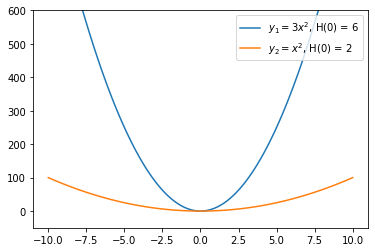

In [438]:
x = np.linspace(-10,10,100)
y_1 = 10*x**2
y_2 = x**2
fig, ax = plt.subplots()
ax.plot(x,y_1,label = '$y_1 = 3x^2$, H(0) = 6')
ax.plot(x,y_2,label = '$y_2 = x^2$, H(0) = 2')
ax.set_ylim(top = 600)
ax.legend(loc = 'upper right')
# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/hessian.png')

In [439]:
def hessian_compute_new(fn,loc):
    f_ = fn
    loc_ = loc
    hess = np.empty([loc.shape[0],loc.shape[0]])
    with tf.GradientTape(persistent=True) as t:  
        t.watch(loc_)
        loss = f_(loc_)
        jacobian = t.gradient(loss,loc_)
        for i in range(loc_.shape[0]):
            hess[i] = t.gradient(jacobian[i],loc_)
    return hess

In [440]:
def f(x):
    return x**2
loc = tf.zeros(1)
hessian_compute_new(f,loc)

array([[2.]])

In [441]:
def f(x):
    return 3*x**2
loc = tf.zeros(1)
hessian_compute_new(f,loc)

array([[6.]])

#### Compute the Hessian and Covariance of the Posterior at MAP

Laplace approximation

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [442]:
cov = tf.convert_to_tensor(cov,dtype = tf.float32)
tf.linalg.inv(cov)

<tf.Tensor: id=138312422, shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [443]:
# C_post = [[5.3157514e-01, 2.5224808e-04],
#        [2.5224808e-04, 9.8040411e-03]]

In [444]:
Sum = tf.add(hess,tf.linalg.inv(cov))
C_post = tf.linalg.inv(Sum)
C_post

<tf.Tensor: id=138312426, shape=(2, 2), dtype=float32, numpy=
array([[ 0.00024361, -0.00048624],
       [-0.00048624,  0.00196855]], dtype=float32)>

Text(0, 0.5, 'x2')

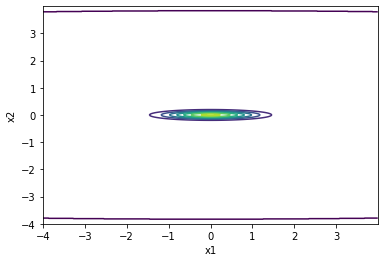

In [344]:
loc  = [0.,0.]
cov = C_post
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.empty(x.shape + (2,)) 
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(loc, cov)
plt.contour(x, y, rv.pdf(pos))
plt.xlabel("x1")
plt.ylabel("x2")

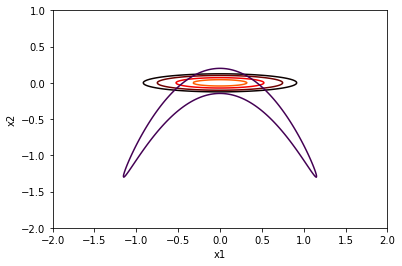

In [357]:
from scipy.stats import multivariate_normal
def plot_dist(loc,cov):
    x, y = np.mgrid[-4:4:.01, -4:4:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(loc, cov)
#     plt.contour(x, y, rv.pdf(pos),np.arange(0.00001,0.0007,0.0001))
    plt.contour(x, y, rv.pdf(pos),[1.,1.3,1.7,2.,3.], cmap=plt.get_cmap('hot'))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_dist(MAP,C_post)

draw_post() 

# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/hess_banana.png')

In [114]:
x

array([-10.        ,  -9.7979798 ,  -9.5959596 ,  -9.39393939,
        -9.19191919,  -8.98989899,  -8.78787879,  -8.58585859,
        -8.38383838,  -8.18181818,  -7.97979798,  -7.77777778,
        -7.57575758,  -7.37373737,  -7.17171717,  -6.96969697,
        -6.76767677,  -6.56565657,  -6.36363636,  -6.16161616,
        -5.95959596,  -5.75757576,  -5.55555556,  -5.35353535,
        -5.15151515,  -4.94949495,  -4.74747475,  -4.54545455,
        -4.34343434,  -4.14141414,  -3.93939394,  -3.73737374,
        -3.53535354,  -3.33333333,  -3.13131313,  -2.92929293,
        -2.72727273,  -2.52525253,  -2.32323232,  -2.12121212,
        -1.91919192,  -1.71717172,  -1.51515152,  -1.31313131,
        -1.11111111,  -0.90909091,  -0.70707071,  -0.50505051,
        -0.3030303 ,  -0.1010101 ,   0.1010101 ,   0.3030303 ,
         0.50505051,   0.70707071,   0.90909091,   1.11111111,
         1.31313131,   1.51515152,   1.71717172,   1.91919192,
         2.12121212,   2.32323232,   2.52525253,   2.72

TypeError: Number of dimensions of x and y should match.

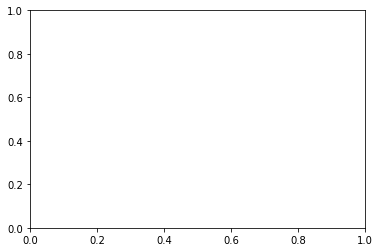

In [111]:
plt.contour(x, y, post,[joint_log_post(D,0.2,0.1),joint_log_post(D,0.1,0.1)])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")



#### Define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}


gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

$\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}$  is the negative log posterior

In [160]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

In [169]:
def negative_log_prob(vars):
    return(tf.negative(joint_log_prob(D,vars[0],vars[1])))

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_prob(m_current),matrixcompute(m_current,MAP,C_post))
    delta_proposed = tf.subtract(negative_log_prob(m_proposed),matrixcompute(m_proposed,MAP,C_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        

In [170]:
from IPython.display import clear_output
# define leaning rate
beta = 0.1

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(np.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed
    

    

In [171]:
mu_init = [1.,1.]

acceptance rate = 84.3%


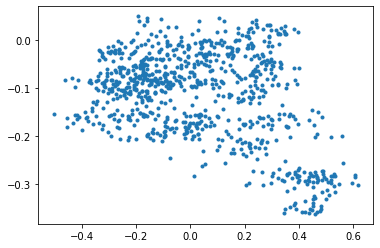

In [322]:
number_of_steps = 1000
def run_chain():
    burn_in = 500
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(accepted[:,0],accepted[:,1],'.')


In [337]:
number_of_steps = 10000
def run_chain():
    burn_in = 0
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()

In [338]:
np.shape(accepted)[0]
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

acceptance rate = 83.4%


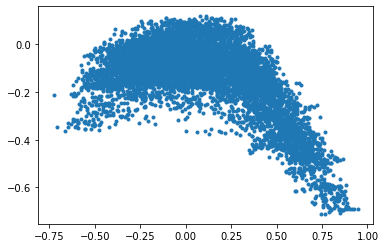

In [340]:
accepted = np.array(accepted)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(accepted[:,0],accepted[:,1],'.')


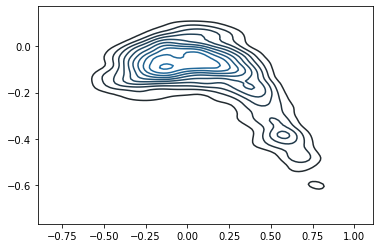

In [339]:
sns.kdeplot(accepted)

### Tascks: 
1.  make a plot of the true density
2.  Create a gempy model, better with gravity


Likelihood

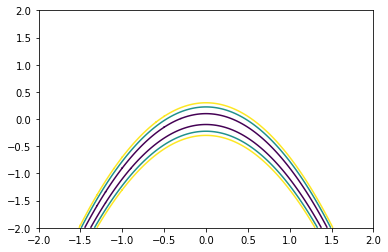

In [30]:
s = 0.01  # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-2, 2+s, s)   #Could use linspace instead if dividing
Y = np.arange(-2, 2.+s, s)   #evenly instead of stepping...

#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

Z =  (Y+X*X)**2

plt.contour(X,Y,Z,[0.01,0.05,0.09])

Prior

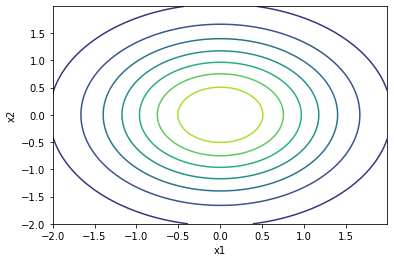

In [31]:
def plot_Prior():
    x, y = np.mgrid[-2:2:.01, -2:2:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    plt.contour(x, y, rv.pdf(pos))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_Prior()

Try again put them in a inference problem

In [113]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (tf.exp(mvn.prob(tf.squeeze(z))
           +tf.reduce_sum(y.prob(D))))

In [114]:
# y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
# tf.reduce_prod(y.prob(D))

In [115]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

post = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        post[i][j] = joint_post_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

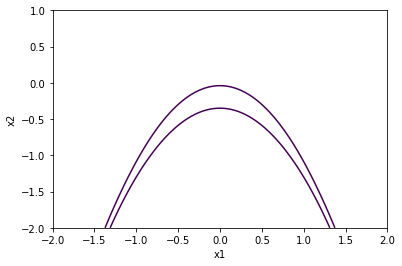

In [116]:
plt.contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")

#### make a function to plot the true density

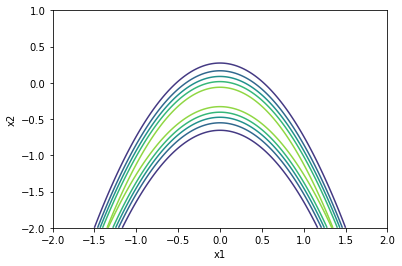

In [117]:
def plot_truepost():
    plt.contour(x, y, post)
    plt.xlim(-2,2)
    plt.ylim(-2,1)
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_truepost()

likelihood

In [102]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def likelihood_prob(y,theta1,theta2):
    # define random variables prior
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)

    return(y.prob(D))

In [104]:
# def multivariate_normal(x, d, mean, covariance):
#     """pdf of the multivariate normal distribution."""
#     x_m = x - mean
#     return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
#             np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [ ]:
def likelihood(mu,sigma,x):
    

In [106]:
likelihood_prob(D,-1.,-1.)

<tf.Tensor: id=50688279, shape=(100,), dtype=float32, numpy=
array([0.11852656, 0.35082045, 0.27916637, 0.3175398 , 0.24357706,
       0.04958992, 0.39865258, 0.3373914 , 0.09527408, 0.30577326,
       0.31244272, 0.38152945, 0.21731788, 0.39882207, 0.28131896,
       0.2559665 , 0.396823  , 0.22954656, 0.38699   , 0.33161986,
       0.28043038, 0.15645514, 0.11792156, 0.25640616, 0.32087597,
       0.38999292, 0.33335066, 0.38605025, 0.35875905, 0.36812472,
       0.24894464, 0.14426139, 0.01804098, 0.09469493, 0.3949512 ,
       0.07429725, 0.37448597, 0.35599464, 0.35783136, 0.39716896,
       0.24605526, 0.26648703, 0.28921586, 0.07252827, 0.33239573,
       0.10574658, 0.04206104, 0.07356273, 0.05766997, 0.39133456,
       0.39744973, 0.14571816, 0.25787392, 0.15151331, 0.27348062,
       0.39223272, 0.37632185, 0.3988246 , 0.17588976, 0.2694407 ,
       0.36813956, 0.3989237 , 0.07935382, 0.2891691 , 0.3915648 ,
       0.17196114, 0.24164866, 0.3337811 , 0.28613952, 0.07877778,
 

In [43]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y
likelihood = np.empty(x.shape)
for i in range(400):
    for j in range(400):
        likelihood[i][j] = likelihood_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

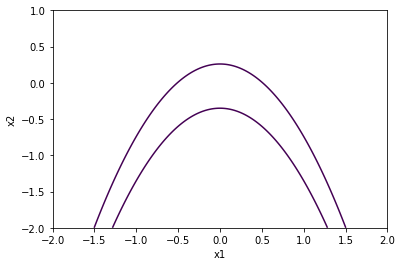

In [44]:
plt.contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")
    

Prior

In [45]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def prior_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    return(mvn.prob(tf.squeeze(z)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

prior = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        prior[i][j] = prior_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

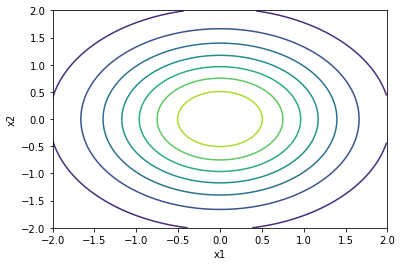

In [46]:
plt.contour(x, y, prior)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Let's add more observations, we shall expect broader extension

In [47]:
c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.prob(tf.squeeze(z))
          +tf.reduce_sum(y.prob(D)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

pdf_1 = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        pdf_1[i][j] = joint_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

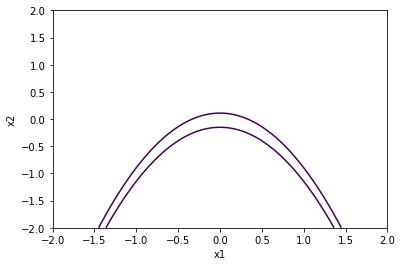

In [48]:
plt.contour(x, y, pdf_1,[joint_prob(D,0.1,0.1).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Plot the results together

In [86]:
likelihood_prob(D,-0.5,-0.35).numpy()

inf

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """
/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Text(0.5, 1.0, '(c) Posterior')

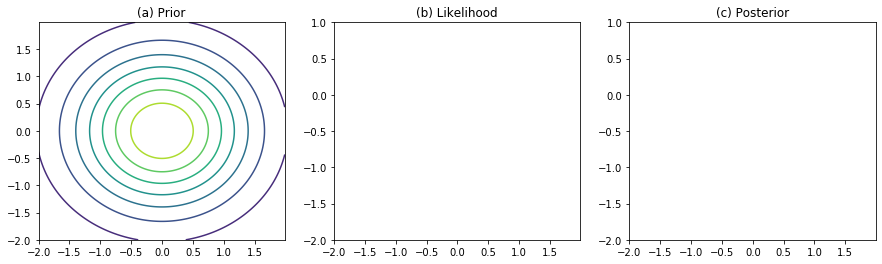

In [88]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

Text(0.5, 1.0, '(c) Posterior')

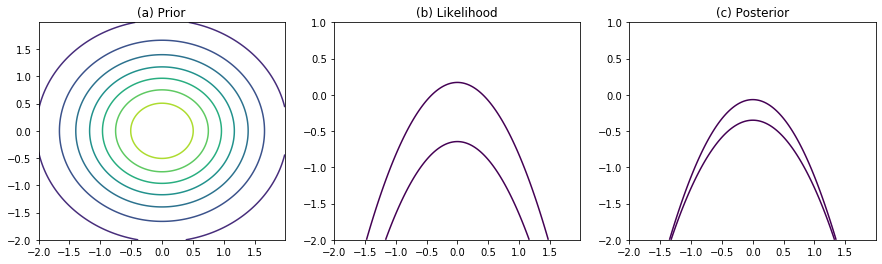

In [318]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

(a) Prior, (b) likelihood and (c) posterior for the warped bivariate Gaussian distribution with n=100 values generated from the likelihood with parameter settings $\sigma_y$,$\sigma$ = 11: as the sample size increases and the prior becomes more diffuse, the posterior becomes less identifiable and the ridge in the posterior becomes stronger 

In [87]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [143]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (mvn.log_prob(tf.squeeze(z))
           +tf.reduce_sum(y.log_prob(D)))

In [8]:
num_results = 5000
burnin = 1000

initial_chain_state = [
    -0. * tf.ones([], dtype=tf.float32, name="init_t1"),
    -0. * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 98.7%


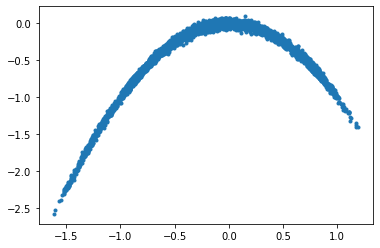

In [9]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
# f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


NameError: name 'plot_dist' is not defined

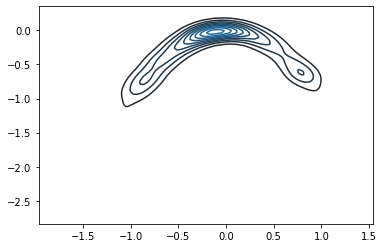

In [22]:
sns.kdeplot(samples)
plot_dist(MAP,C_post)